<a href="https://colab.research.google.com/github/LuigTi/CNN_NAS2/blob/main/CNN_NAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing libraries

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

### Dataset Class

In [20]:
class DigitsDataset(Dataset):
    '''
    Digit database from scikit-learn
    '''

    def __init__(self, mode = "train", transforms = None):
        digits = load_digits()

        #select the first 1000 datapoints as training set
        if mode == "train": 
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]

        #select 350 datapoints as training set
        elif mode == "val": 
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        
        #select the remaining datapoints as test set
        else: 
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]       
        #reshape datapoints from vector to matrix
        sample_x = sample_x.reshape(1, 8, 8) 
        sample_y = self.targets[idx]
        
        if torch.cuda.is_available(): #move on gpu if possible
          sample_x = torch.from_numpy(sample_x).to("cuda")
          sample_y = torch.from_numpy(np.array(sample_y)).to("cuda")

        return (sample_x, sample_y)

### CNN Class

In [21]:
class CNN(nn.Module):
    '''
    following the structure of:
      Conv2d → f(.) → Pooling → Flatten → Linear 1 → f(.) → Linear 2 → Softmax

    ● Conv2d:
        ○ Number of filters: 8, 16, 32
        ○ kernel=(3,3), stride=1, padding=1 OR kernel=(5,5), stride=1, padding=2
    ● f(.):
        ○ ReLU OR sigmoid OR tanh OR softplus OR ELU
    ● Pooling:
        ○ 2x2 OR Identity
        ○ Average OR Maximum
    ● Linear 1:
        ○ Number of neurons: 10, 20, 30, 40, 50, 60, 70, 80, 90, 100

    '''
    #rinomina tutto, 
    
    def __init__(self, 
                 conv_out = 8, # Number of filters: 8, 16, 32
                 kernel_params = 0, #0 OR 1
                      #0=> kernel=(3,3), stride=1, padding=1
                      #1=> kernel=(5,5), stride=1, padding=2
                 f1 = "ReLU", #possible activation functions:
                      #ReLU OR Sigmoid OR Tanh OR Softplus OR ELU
                 f2 = "ReLU", #possible activation functions:
                      #ReLU OR Sigmoid OR Tanh OR Softplus OR ELU                 
                 pool_size = 2,  #2, identity
                 pooling = "avg", # avg, max
                 linear_out = 10 #10,20,30,40,50,60,70,80,90,100
                 ):
        super(CNN, self).__init__()


        #adjust the parameters depending on the input
        self.conv_out = conv_out 
        if kernel_params == 0: #kernel=(3,3), stride=1, padding=1
            self.kernel_size = 3 
            self.padding = 1 
        else:
            self.kernel_size = 5 
            self.padding = 2

        if pool_size == 2:
            self.pool_size = 2
        else:
            self.pool_size = 1

        self.linear_out = linear_out # Number of neurons

        #find the size of the tensor cefore entering the fully connected layer
        if True:
          #find the size after the convolutional layers
          size = 8 - self.kernel_size + 2 * self.padding + 1
          #find the size after the pooling layer
          size = (size - self.pool_size) / (self.pool_size) + 1
          #find the size after flattening
          size = int(size**2 * self.conv_out)


        #convolutional layers
        self.cnn =  nn.Conv2d(in_channels = 1, out_channels = conv_out, kernel_size = self.kernel_size, stride = 1, padding = self.padding)

        #activation function 1
        if f1 == "ReLU":    
            self.activation1 = nn.ReLU()
        elif f1 == "Sigmoid":
            self.activation1 = nn.Sigmoid()
        if f1 == "Tanh":    
            self.activation1 = nn.Tanh() 
        elif f1 == "Softplus":
            self.activation1 = nn.Softplus()
        elif f1 == "ELU":
            self.activation1 = nn.ELU()

        #pooling
        if pooling == "avg":
            self.pool = nn.AvgPool2d(kernel_size = pool_size)
        else:
            self.pool = nn.MaxPool2d(kernel_size = pool_size)
       
        #fully connected layer 1
        self.linear1 = nn.Linear(in_features = size, out_features = self.linear_out)

        #activation function 2
        if f2 == "ReLU":    
            self.activation2 = nn.ReLU()
        elif f2 == "Sigmoid":
            self.activation2 = nn.Sigmoid()
        if f2 == "Tanh":    
            self.activation2 = nn.Tanh() 
        elif f2 == "Softplus":
            self.activation2 = nn.Softplus()
        elif f2 == "ELU":
            self.activation2 = nn.ELU()

        #fully connected layer 1
        self.linear2 = nn.Linear(in_features = self.linear_out, out_features = 10)
        #softmax
        self.softmax = nn.LogSoftmax(dim=1)

        #loss funtion
        self.nll = nn.NLLLoss(reduction="none") 
    
    #classify method to find the prediccion of a datapoint
    def classify(self, x):
        #input goes through all the layers
        x = self.cnn(x)
        x = self.activation1(x)
        x = self.pool(x)
        #get flattened before fully conneted layers
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.activation2(x)
        x = self.linear2(x)
        log_prob = self.softmax(x)
        #find prediction
        y_pred = torch.argmax(log_prob, dim = 1).long()        
        return y_pred

    #foward method for the foward pass
    def forward(self, x, y, reduction="avg"):
        #input goes through all the layers
        x = self.cnn(x)
        x = self.activation1(x)
        x = self.pool(x)
        #get flattened before fully conneted layers
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.activation2(x)
        x = self.linear2(x)
        log_prob = self.softmax(x)
        
        #find the loss (it has as input the log_prob and targets)
        loss = self.nll(log_prob, y)
        #reduction for loss over a batch (either summ or mean)
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

    #find how many classifying mistakes were made
    def missclassified_datapoints(self, predictions, targets):
        #number of differences in the two vectors
        return torch.sum(predictions != targets) 

### Train and Evaluation Loops (one epoch) and Plot Function

In [22]:
def train_loop(dataloader, model, optimizer, verbose = True):

    #counters for train loss and missclassified and total datapoints
    loss_counter = 0
    missclass_counter = 0
    total_data_points = 0

    #get model on train mode
    model.train()

    #for datapoint and target in dataloader
    for (X, y) in dataloader:

        #get batch size
        batch_size = X.size(0)

        #find the loss by giving a prediction regarding the datapoint
        loss = model(X, y, reduction = "sum")
        #add loss to counter
        loss_counter += loss

        #classify each datapoint and count missclassified points
        predictions = model.classify(X)
        missclassified_datapoints = model.missclassified_datapoints(predictions, y)
        #add missclassified datapoints to counter
        missclass_counter += missclassified_datapoints


        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #update total
        total_data_points += batch_size

    
    #find average loss and average classification error over the epoch 
    average_loss = float(loss_counter / total_data_points)
    average_ce = float(missclass_counter / total_data_points)
    if verbose == True:
      #print average loss and average classification error 
      print("\033[95mTRAINING\033[0m")
      print(f"        average train loss => {average_loss}")
      print(f"        average classification error => {average_ce}")
      print("")
      
    return average_loss, average_ce


In [23]:
def evaluation_loop(dataloader, model, mode = "validation", verbose = True):

    #counters for train loss and missclassified datapoints
    loss_counter = 0
    missclass_counter = 0

    #get model to eval mode
    model.eval()


    #to not save the gradients
    with torch.no_grad():
      #for datapoint and target in dataloader
      for (X, y) in dataloader:


        #find the loss by giving a prediction regarding the datapoint
        loss = model(X, y, reduction = "sum")
        #add loss to counter
        loss_counter += loss

        #classify each datapoint and count missclassified points
        predictions = model.classify(X)
        missclassified_datapoints = model.missclassified_datapoints(predictions, y)
        #add missclassified datapoints to counter
        missclass_counter += missclassified_datapoints



    #find average loss and average classification error over the epoch 
    dataloader_size = len(dataloader.dataset)
    average_loss = float(loss_counter / dataloader_size)
    average_ce = float(missclass_counter / dataloader_size)
    if verbose == True:
      #print average loss and average classification error 
      if mode == "validation":
        print("\033[95mVALIDATION\033[0m")
      else:
        print("\033[92mTESTING\033[0m")

      print(f"        average {mode} loss => {average_loss}")
      print(f"        average {mode} classification error => {average_ce}")
      print("")

    return average_loss, average_ce


In [24]:
#function to plot
def plot_results(train_loss_list, train_ce_list, val_loss_list, val_ce_list, test_loss_list = None, test_ce_list = None):
    #number of epoches
    n_epochs = len(train_loss_list)
    # Plotting train loss
    plt.plot(range(1, n_epochs + 1), train_loss_list, label="Train Loss")

    # Plotting train classification error
    plt.plot(range(1, n_epochs + 1), train_ce_list, label="Train Classification Error")

    # Plotting validation loss
    plt.plot(range(1, n_epochs + 1), val_loss_list, label="Validation Loss")

    # Plotting validation classification error
    plt.plot(range(1, n_epochs + 1), val_ce_list, label="Validation Classification Error")

    if test_loss_list != None and test_ce_list != None:
      # Plotting test loss
      plt.plot(range(1, n_epochs + 1), [test_loss_list] * n_epochs, label="Test Loss", linestyle="--")

      # Plotting test classification error
      plt.plot(range(1, n_epochs + 1), [test_ce_list] * n_epochs, label="Test Classification Error", linestyle="--")

    #labels and title
    plt.xlabel("Epochs")
    plt.ylabel("Loss / Classification Error")
    plt.title("Training and Evaluation Results")
    plt.legend()

    #show the plot
    plt.show()

### Dataloaders and Full Training and Testing

In [25]:
#training, validation and test sets.
train_set = DigitsDataset(mode="train")
val_set = DigitsDataset(mode="val")
test_set = DigitsDataset(mode="test")

#data loaders.
training_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


In [26]:
def full_cnn_loop(model, number_epoch = 20, testing = True, training_loader = None, val_loader = None, test_loader = None, verbose = True):


    for param in model.parameters():
      param.requires_grad = True
    opt = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)
    #initialize empty lists
    train_loss_list = []
    train_ce_list = []
    val_loss_list =[]
    val_ce_list =[]
    test_loss_list =[]
    test_ce_list =[]

    
    #progress bar if verbose
    if verbose:
      loop = tqdm(range(number_epoch))
    else:
      loop = range(number_epoch)
      
    #for number of epoches
    for i in loop:
      
      if verbose == True:
        print(f"\033[96mEPOCH NUMBER {i}\033[0m")

      #train loop
      train_loss, train_ce =  train_loop(dataloader = training_loader, model = model, optimizer = opt, verbose = verbose)
      train_loss_list.append(train_loss)
      train_ce_list.append(train_ce)

      #validation loop
      val_loss, val_ce = evaluation_loop(dataloader = val_loader, model = model, verbose = verbose)
      val_loss_list.append(val_loss)
      val_ce_list.append(val_ce)

    #testing loop (only if in testing mode)
    if testing == True:
      test_loss, test_ce = evaluation_loop(dataloader = test_loader, model = model, mode = "test", verbose = verbose)
      test_loss_list.append(test_loss)
      test_ce_list.append(test_ce)
    else:
      test_loss_list = None
      test_ce_list = None

    #plot graphs
    if verbose == True:
       plot_results(train_loss_list, train_ce_list, val_loss_list, val_ce_list, test_loss_list, test_ce_list)

    if testing == True: #if in testing mode
      return min(test_loss_list), max(test_ce_list)
    else: #if in validation mode
      return  min(val_loss_list), max(val_ce_list)


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 2.7781906127929688
        average classification error => 0.8980000615119934

VALIDATION
        average validation loss => 2.377981185913086
        average validation classification error => 0.8857142925262451

EPOCH NUMBER 1
TRAINING
        average train loss => 2.3173437118530273
        average classification error => 0.8500000238418579

VALIDATION
        average validation loss => 2.2658462524414062
        average validation classification error => 0.8085713982582092

EPOCH NUMBER 2
TRAINING
        average train loss => 2.250809907913208
        average classification error => 0.8190000653266907

VALIDATION
        average validation loss => 2.2128658294677734
        average validation classification error => 0.8600000143051147

EPOCH NUMBER 3
TRAINING
        average train loss => 2.208683967590332
        average classification error => 0.8470000624656677

VALIDATION
        average validation loss => 2.179566621780395

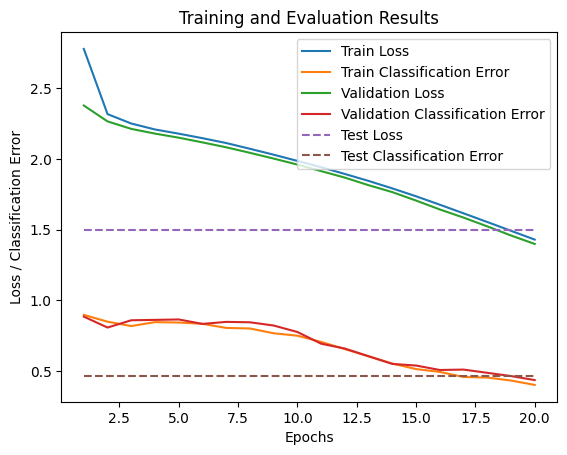

In [27]:
#example of a fool loop (no specified params for the architecture)
Random_model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Random_model.to(device)
_,_ = full_cnn_loop(model = Random_model, number_epoch = 20, testing = True, training_loader = training_loader, val_loader = val_loader, test_loader = test_loader)

### Neuroevolutionary Algorithm Class


GIVEN THAT THE FOLLOWING ARE THE POSSIBILITIES:

conv_out = 8, 16, 32

* kernel_params = 0, 1

    0=> kernel=(3,3), stride=1, padding=1
          
    1=> kernel=(5,5), stride=1, padding=2


* f1 = ReLU OR Sigmoid OR Tanh OR Softplus OR ELU     


* f2 = ReLU OR Sigmoid OR Tanh OR Softplus OR ELU          


* pool_size = 2, identity

* pooling =  avg, max

* linear_out = 10,20,30,40,50,60,70,80,90,100

THE FOLLOWING IS THE ENCODING:

**[conv_out, kernel_params, f1, f2, pool_size, pooling, linear_out]**

where their **RANGE** is:

  * conv_out => 0-1-2

  * kernel_params => 0-1
  
  * f1 => 0-1-2-3-4
  
  * f2 => 0-1-2-3-4
  
  * pool_size => 0-1
  
  * pooling => 0-1

  * linear_out => 0-1-2-3-4-5-6-7-8-9


In [28]:
class EA(object):
    def __init__(self, number_epoch = 10, pop_size = 10, p_parents = 0.8, nr_parents = 5, nr_candidate_child = 12):

        self.number_epoch = number_epoch #number epoch for each evaluation
        self.pop_size = pop_size #size of a population
        self.p_parents = p_parents #percentage of top indivuals from old generation taken as possible parents
        self.nr_parents = nr_parents #parents taken from each each generation
        self.nr_candidate_child = nr_candidate_child #candidate children after each recombination

        #max value of each entry (min is always 0)
        self.conv_out_max = 2
        self.kernel_params_max = 1
        self.f1_max = 4
        self.f2_max = 4
        self.pool_size_max = 1
        self.pooling_max = 2
        self.linear_out = 9


        #training, validation and test sets
        self.train_set = DigitsDataset(mode="train")
        self.val_set = DigitsDataset(mode="val")
        #data loaders
        self.training_loader = DataLoader(self.train_set, batch_size=64, shuffle=True)
        self.val_loader = DataLoader(self.val_set, batch_size=64, shuffle=False)
       
      
    def parent_selection(self, x_old, f_old):

        #sort parents from best to worst fistness
        sorted_index = np.argsort(f_old)
        sorted_x_parents = np.array(x_old)[sorted_index]
        sorted_f_parents = np.array(f_old)[sorted_index]
        
        #p = hyperparameter
        p = float(self.p_parents)

        #the number of individuals in p percent
        range_p = int(self.pop_size * p)
        parents_list=[]
        parent_fitness =[]

        #for self.nr_parents times, sample with replacement (from the 100p best individuals from the old generaton)
        for i in range(self.nr_parents):
          #random index within the top range
          top_index = np.random.choice(range(range_p), size=1)
          #get individual at the randomly selected index from the top range
          random_top_ind = sorted_x_parents[top_index]
          random_top_ind_fitness = sorted_f_parents[top_index]
          #add the new parent to the list
          parents_list.append(random_top_ind)
          parent_fitness.append(random_top_ind_fitness)
        #turn list into numpy array
        array_parents = np.stack(parents_list).reshape((self.nr_parents, 7))    

        return array_parents, parent_fitness



    def recombination(self, x_parents, f_parents):
        candidate_children = []
        pop_size = len(x_parents)
        #since each loop 2 children are made => nr_candidate_child/2
        for i in range(int(self.nr_candidate_child/2)):

          #pick two random parents
          idx1, idx2 = np.random.choice(pop_size, size=2, replace=False)
          parent1 = x_parents[idx1]
          parent2 = x_parents[idx2]

          #pick a random number from 1 to 5
          random_number = np.random.randint(1, 6)

          #split the parents into two halves
          half1_1 = x_parents[idx1][:random_number]
          half1_2 = x_parents[idx1][random_number:]
          half2_1 = x_parents[idx2][:random_number]
          half2_2 = x_parents[idx2][random_number:]

          #make the children as the cobination of two (un-paired) halves
          child1 = np.concatenate((half1_1, half2_2))
          child2 = np.concatenate((half2_1, half1_2))
          candidate_children.append(child1)
          candidate_children.append(child2)

        #turn list into numpy array of the right size 
        candidate_children = np.vstack(candidate_children)

        return candidate_children



    def mutation(self, x_children):    
        mutated_children = []
        for x_child in x_children:
            ex = [self.conv_out_max, self.kernel_params_max, self.f1_max, self.f2_max,self.pool_size_max, self.pooling_max,self.linear_out ]
            #pick a random number from 0 to 6
            random_number = np.random.randint(0, 7)
            
            #if the value of the entry picked is 0, add one
            if x_child[random_number] == 0:
              x_child[random_number] = x_child[random_number] + 1
            #if the value of the entry picked is the max, subtract 1
            elif x_child[random_number] == ex[random_number]:
              x_child[random_number] = x_child[random_number] - 1
            #if the value of the entry picked is not the max nor the min, either add or subtract 1
            else:
              random_choice = np.random.choice([-1, 1])
              x_child[random_number] = x_child[random_number] + random_choice
            mutated_children.append(x_child)

        mutated_children = np.vstack(mutated_children)
        return mutated_children 



    def survivor_selection(self, x_old, x_children, f_old, f_children):
        #combine parent and children populations
        x = np.vstack([x_old, x_children])
        f = np.concatenate([f_old, f_children])
        
        #select the best individuals based on their fitness
        idx_sorted = np.argsort(f)
        x_sorted = x[idx_sorted]
        
        #keep the top individuals as the new population
        x_survivors = x_sorted[:self.pop_size]
        f_survivors = f[idx_sorted][:self.pop_size]
        return x_survivors, f_survivors



    def evaluate(self, x_pop):
        f = []

        #for each architecture in the population
        for x in x_pop:
          #convert genotype into usable paarameters
          y = self.nn_from_genotype(x)
          #initialize cnn and move it to CUDA if available
          cnn_to_evaluate =  CNN(conv_out = y[0], 
                                kernel_params = y[1], 
                                f1 = y[2],
                                f2 = y[3],               
                                pool_size = y[4],
                                pooling = y[5],
                                linear_out = y[6] )
          cnn_to_evaluate.to(device)

          _, validation_ce = full_cnn_loop(model = cnn_to_evaluate, number_epoch = self.number_epoch, testing = False, training_loader = self.training_loader, val_loader = self.val_loader, verbose = False)                 
          
          #count number of parameters in the CNN
          num_parameters = sum(p.numel() for p in cnn_to_evaluate.parameters())
          num_params_max = 206742
          #Objective = ClassError + λ * Np/Nmax
          fitness_x = validation_ce + 0.01*(num_parameters/num_params_max)
          f.append(fitness_x)

        return f

    @staticmethod
    def nn_from_genotype(genotype):
        '''
        transform genotype into parameters usable to create the CNN
        it follows the schema described above
        '''

        y = []
        #conv_out = 8, 16, 32
        if genotype[0] == 0:
          y.append(8)
        elif genotype[0] == 1:
          y.append(16)
        else:
          y.append(32)

        #kernel params= 0 or 1
        y.append(genotype[1])

        #f1= ReLU OR Sigmoid OR Tanh OR Softplus OR ELU
        if genotype[2] == 0:
          y.append("ReLU")
        elif genotype[2] == 1:
          y.append("Sigmoid")
        elif genotype[2] == 2:
          y.append("Tanh")
        elif genotype[2] == 3:
          y.append("Softplus")
        else:
          y.append("ELU")

        #f1= ReLU OR Sigmoid OR Tanh OR Softplus OR ELU
        if genotype[3] == 0:
          y.append("ReLU")
        elif genotype[3] == 1:
          y.append("Sigmoid")
        elif genotype[3] == 2:
          y.append("Tanh")
        elif genotype[3] == 3:
          y.append("Softplus")
        else:
          y.append("ELU")

        #pool_size = 2 or identity
        if genotype[3] == 0:
          y.append(2)
        else: 
          y.append(1)

        #pooling = avg, max
        if genotype[5] == 0:
          y.append("avg")
        else:
          y.append("max")
        
        #linear_out = 10,20,30,40,50,60,70,80,90,100
        a =  int(genotype[6])
        b = (a+1)*10
        y.append(b)
        
        #return the parameters 
        return y

    def step(self, x_old, f_old):

        x_parents, f_parents = self.parent_selection(x_old, f_old) # return a subset of the old population / parents and how fit they are

        x_children = self.recombination(x_parents, f_parents) # compute a set of INITIAL candidate solutions

        x_children = self.mutation(x_children)  # compute a set of FINAL candidate solutions, that are modified with perturbation

        f_children = self.evaluate(x_children) # compute the fitness of the FINAL candidate solutions

        x, f = self.survivor_selection(x_old, x_children, f_old, f_children) # select the new population from the old population and the FINAL candidate solutions (or solely from the FINAL candidate solutions)<= commenting the code before implementing

        return x, f # return the new population and their fitness

### Running Loop ###

In [29]:
def create_random_idividual():

  ''' Given the following:
        conv_out_max = 2
        kernel_params_max = 1
        f1_max = 4
        f2_max = 4
        pool_size_max = 1
        pooling_max = 2
        linear_out = 9
  '''

  individual = []
  
  #define the range for each entry
  entry_ranges = [
      2,    # Range for entry 1
      1,    # Range for entry 2
      4,    # Range for entry 3
      4,    # Range for entry 4
      1,    # Range for entry 5
      2,    # Range for entry 6
      9     # Range for entry 7
  ]
    
  #generate a random integer within each range and append to the vector
  for entry_range in entry_ranges:
      entry = random.randint(0, entry_range)
      individual.append(entry)
    
  return individual

In [35]:
num_generations = 50
population_size = 30

ea = EA(number_epoch = 6, pop_size = population_size, p_parents = 0.4, nr_parents = 20, nr_candidate_child = 40)


#init the population
x = [create_random_idividual() for _ in range(population_size)]
f = ea.evaluate(x)

# gather populations and values of the best candidates to further
#analyze the algorithm.
populations = []
populations.append(x)
f = np.array(f)
f_best = [f.min()]
best_individual = [x[np.argmin(f)]]

#run the EA.
for i in tqdm(range(num_generations)):
    if i % int(num_generations * 0.1) == 0:
        print("Generation: {}, best fitness: {:.2f}".format(i, f.min()))
    x, f = ea.step(x, f)
    populations.append(x)
    if f.min() < f_best[-1]:
        f_best.append(f.min())
        best_individual.append(x[np.argmin(f)])
    else:
        f_best.append(f_best[-1])
        best_individual.append(best_individual[-1])

print("FINISHED!")

  0%|          | 0/50 [00:00<?, ?it/s]

Generation: 0, best fitness: 0.09
Generation: 5, best fitness: 0.06
Generation: 10, best fitness: 0.05
Generation: 15, best fitness: 0.05
Generation: 20, best fitness: 0.05
Generation: 25, best fitness: 0.05
Generation: 30, best fitness: 0.05
Generation: 35, best fitness: 0.05
Generation: 40, best fitness: 0.05
Generation: 45, best fitness: 0.05
FINISHED!


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.4992038011550903
        average classification error => 0.3460000157356262

VALIDATION
        average validation loss => 1.033751368522644
        average validation classification error => 0.1314285695552826

EPOCH NUMBER 1
TRAINING
        average train loss => 0.8130804300308228
        average classification error => 0.07200000435113907

VALIDATION
        average validation loss => 0.7270409464836121
        average validation classification error => 0.06857142597436905

EPOCH NUMBER 2
TRAINING
        average train loss => 0.5715280771255493
        average classification error => 0.03800000250339508

VALIDATION
        average validation loss => 0.5531048774719238
        average validation classification error => 0.05714285746216774

EPOCH NUMBER 3
TRAINING
        average train loss => 0.43972644209861755
        average classification error => 0.029000001028180122

VALIDATION
        average validation loss => 0.459061

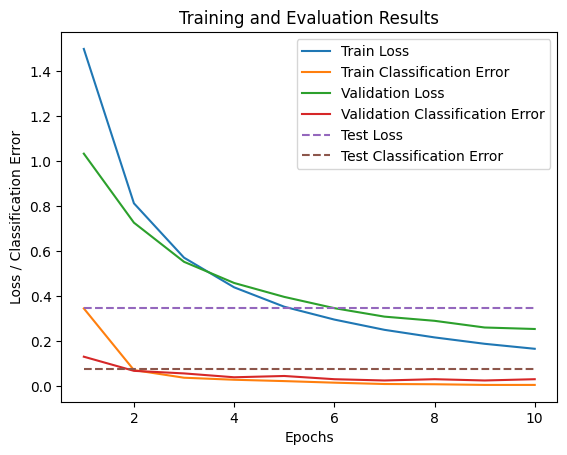

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.4481704235076904
        average classification error => 0.2939999997615814

VALIDATION
        average validation loss => 0.9898059964179993
        average validation classification error => 0.10571428388357162

EPOCH NUMBER 1
TRAINING
        average train loss => 0.7701894044876099
        average classification error => 0.06800000369548798

VALIDATION
        average validation loss => 0.6820111870765686
        average validation classification error => 0.0714285671710968

EPOCH NUMBER 2
TRAINING
        average train loss => 0.552617609500885
        average classification error => 0.04700000211596489

VALIDATION
        average validation loss => 0.5553764700889587
        average validation classification error => 0.05714285746216774

EPOCH NUMBER 3
TRAINING
        average train loss => 0.4289458394050598
        average classification error => 0.032999999821186066

VALIDATION
        average validation loss => 0.4492681

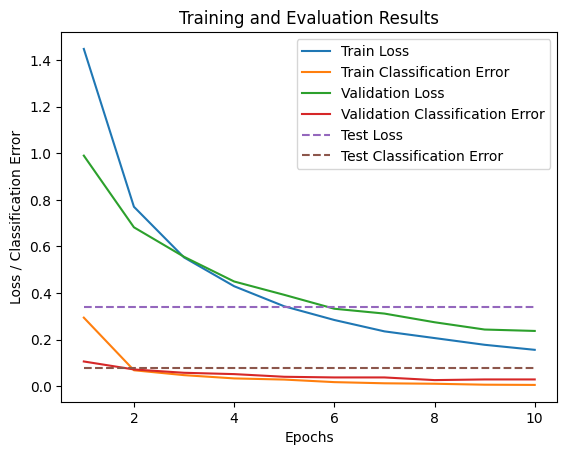

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.3511112928390503
        average classification error => 0.32600000500679016

VALIDATION
        average validation loss => 0.5758447051048279
        average validation classification error => 0.08285713940858841

EPOCH NUMBER 1
TRAINING
        average train loss => 0.340966135263443
        average classification error => 0.06700000166893005

VALIDATION
        average validation loss => 0.28892087936401367
        average validation classification error => 0.0714285671710968

EPOCH NUMBER 2
TRAINING
        average train loss => 0.16789774596691132
        average classification error => 0.032999999821186066

VALIDATION
        average validation loss => 0.21493515372276306
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 3
TRAINING
        average train loss => 0.11794255673885345
        average classification error => 0.02500000037252903

VALIDATION
        average validation loss => 0.1

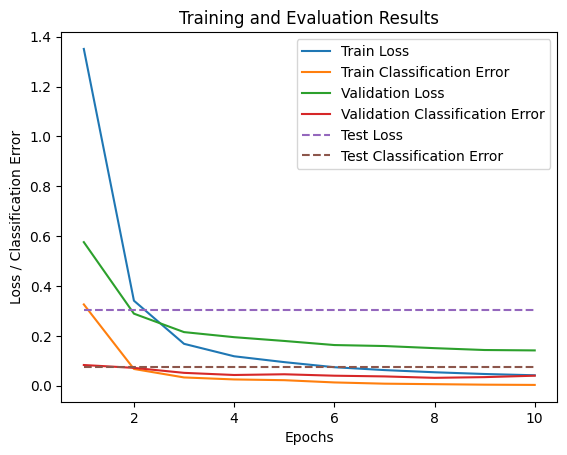

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.4820510149002075
        average classification error => 0.4320000112056732

VALIDATION
        average validation loss => 0.6900299191474915
        average validation classification error => 0.12857142090797424

EPOCH NUMBER 1
TRAINING
        average train loss => 0.4330987334251404
        average classification error => 0.0860000029206276

VALIDATION
        average validation loss => 0.3288955092430115
        average validation classification error => 0.06285714358091354

EPOCH NUMBER 2
TRAINING
        average train loss => 0.2233489602804184
        average classification error => 0.04700000211596489

VALIDATION
        average validation loss => 0.2291950136423111
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 3
TRAINING
        average train loss => 0.15441687405109406
        average classification error => 0.036000002175569534

VALIDATION
        average validation loss => 0.1886

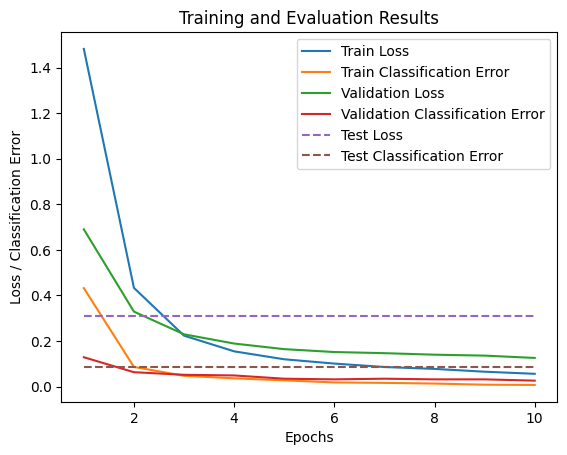

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.4940437078475952
        average classification error => 0.4610000252723694

VALIDATION
        average validation loss => 0.6007367968559265
        average validation classification error => 0.10285714268684387

EPOCH NUMBER 1
TRAINING
        average train loss => 0.41305822134017944
        average classification error => 0.0950000062584877

VALIDATION
        average validation loss => 0.26870885491371155
        average validation classification error => 0.0657142847776413

EPOCH NUMBER 2
TRAINING
        average train loss => 0.21756169199943542
        average classification error => 0.05400000140070915

VALIDATION
        average validation loss => 0.22256848216056824
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 3
TRAINING
        average train loss => 0.1613484025001526
        average classification error => 0.04400000348687172

VALIDATION
        average validation loss => 0.1799

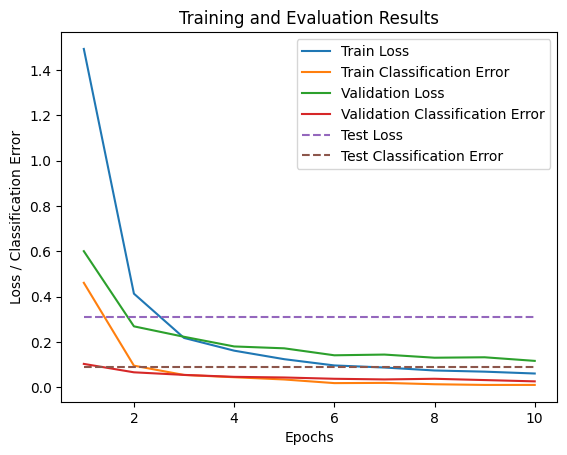

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.3951337337493896
        average classification error => 0.4090000092983246

VALIDATION
        average validation loss => 0.5893222689628601
        average validation classification error => 0.11142857372760773

EPOCH NUMBER 1
TRAINING
        average train loss => 0.36191222071647644
        average classification error => 0.08100000023841858

VALIDATION
        average validation loss => 0.30475053191185
        average validation classification error => 0.07999999821186066

EPOCH NUMBER 2
TRAINING
        average train loss => 0.21158111095428467
        average classification error => 0.055000003427267075

VALIDATION
        average validation loss => 0.23195824027061462
        average validation classification error => 0.05714285746216774

EPOCH NUMBER 3
TRAINING
        average train loss => 0.157570481300354
        average classification error => 0.039000000804662704

VALIDATION
        average validation loss => 0.2018

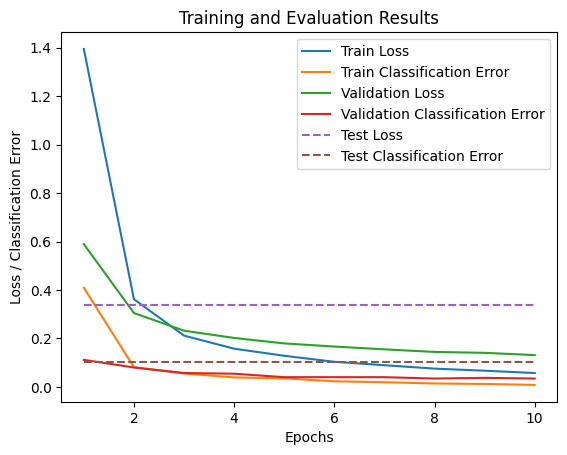

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 0.8819375038146973
        average classification error => 0.25200000405311584

VALIDATION
        average validation loss => 0.2524588704109192
        average validation classification error => 0.06285714358091354

EPOCH NUMBER 1
TRAINING
        average train loss => 0.14450466632843018
        average classification error => 0.03500000014901161

VALIDATION
        average validation loss => 0.1440887600183487
        average validation classification error => 0.02857142873108387

EPOCH NUMBER 2
TRAINING
        average train loss => 0.07771337777376175
        average classification error => 0.02200000174343586

VALIDATION
        average validation loss => 0.1187816634774208
        average validation classification error => 0.037142857909202576

EPOCH NUMBER 3
TRAINING
        average train loss => 0.054365601390600204
        average classification error => 0.010000000707805157

VALIDATION
        average validation loss => 0

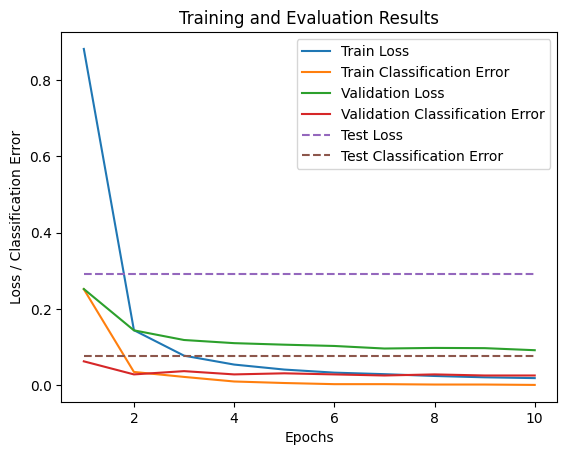

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 0.9834418296813965
        average classification error => 0.3020000159740448

VALIDATION
        average validation loss => 0.3071419298648834
        average validation classification error => 0.07428571581840515

EPOCH NUMBER 1
TRAINING
        average train loss => 0.2031422257423401
        average classification error => 0.05900000408291817

VALIDATION
        average validation loss => 0.20108146965503693
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 2
TRAINING
        average train loss => 0.11078381538391113
        average classification error => 0.029000001028180122

VALIDATION
        average validation loss => 0.16626659035682678
        average validation classification error => 0.04285714402794838

EPOCH NUMBER 3
TRAINING
        average train loss => 0.07334188371896744
        average classification error => 0.014000000432133675

VALIDATION
        average validation loss => 0.

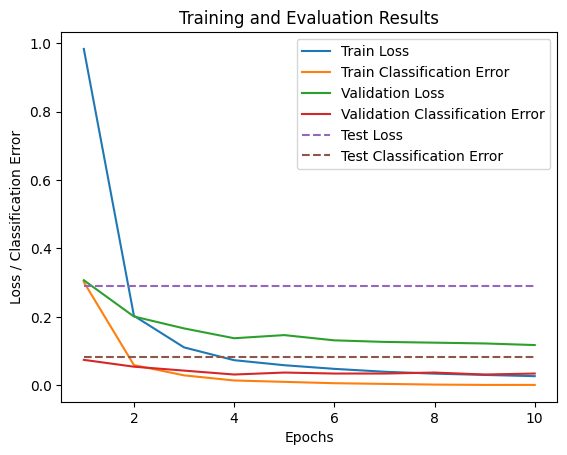

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.2160890102386475
        average classification error => 0.3290000259876251

VALIDATION
        average validation loss => 0.4213888645172119
        average validation classification error => 0.09714285284280777

EPOCH NUMBER 1
TRAINING
        average train loss => 0.2606384754180908
        average classification error => 0.06400000303983688

VALIDATION
        average validation loss => 0.23868753015995026
        average validation classification error => 0.07428571581840515

EPOCH NUMBER 2
TRAINING
        average train loss => 0.13175898790359497
        average classification error => 0.03200000151991844

VALIDATION
        average validation loss => 0.17054761946201324
        average validation classification error => 0.03999999910593033

EPOCH NUMBER 3
TRAINING
        average train loss => 0.096138596534729
        average classification error => 0.023000001907348633

VALIDATION
        average validation loss => 0.149

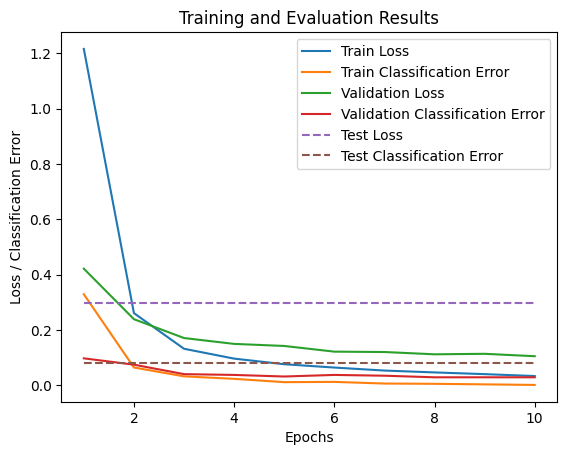

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 0.860200822353363
        average classification error => 0.2370000183582306

VALIDATION
        average validation loss => 0.27347439527511597
        average validation classification error => 0.07428571581840515

EPOCH NUMBER 1
TRAINING
        average train loss => 0.16859164834022522
        average classification error => 0.04800000041723251

VALIDATION
        average validation loss => 0.19992579519748688
        average validation classification error => 0.04571428522467613

EPOCH NUMBER 2
TRAINING
        average train loss => 0.11268666386604309
        average classification error => 0.03100000135600567

VALIDATION
        average validation loss => 0.17064672708511353
        average validation classification error => 0.048571426421403885

EPOCH NUMBER 3
TRAINING
        average train loss => 0.07691296190023422
        average classification error => 0.014000000432133675

VALIDATION
        average validation loss => 0

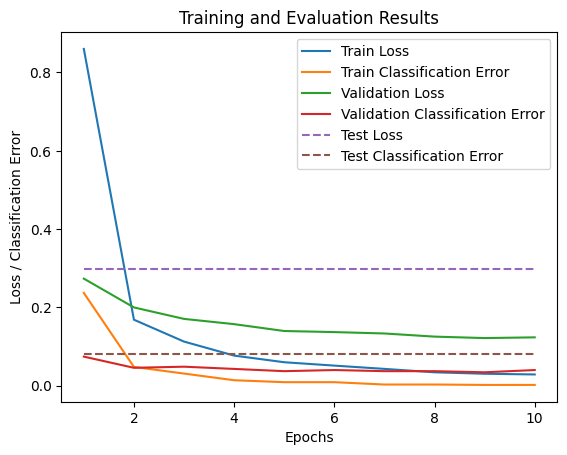

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 0.6567299365997314
        average classification error => 0.1940000057220459

VALIDATION
        average validation loss => 0.17729854583740234
        average validation classification error => 0.04571428522467613

EPOCH NUMBER 1
TRAINING
        average train loss => 0.11724213510751724
        average classification error => 0.029000001028180122

VALIDATION
        average validation loss => 0.1559363454580307
        average validation classification error => 0.04571428522467613

EPOCH NUMBER 2
TRAINING
        average train loss => 0.07187539339065552
        average classification error => 0.017000000923871994

VALIDATION
        average validation loss => 0.13063322007656097
        average validation classification error => 0.02857142873108387

EPOCH NUMBER 3
TRAINING
        average train loss => 0.05298643186688423
        average classification error => 0.009000000543892384

VALIDATION
        average validation loss => 

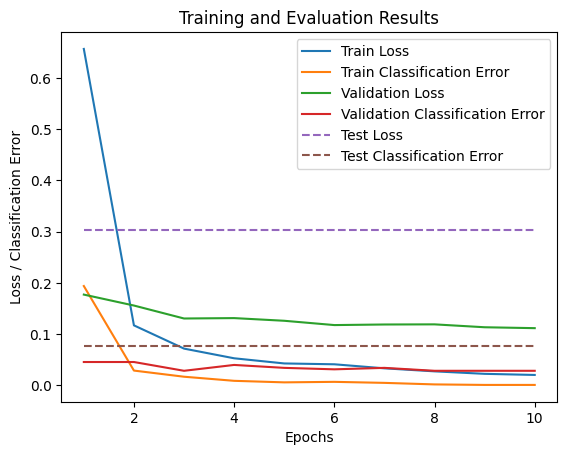

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.1578606367111206
        average classification error => 0.3060000240802765

VALIDATION
        average validation loss => 0.2870177626609802
        average validation classification error => 0.0657142847776413

EPOCH NUMBER 1
TRAINING
        average train loss => 0.22417466342449188
        average classification error => 0.06200000271201134

VALIDATION
        average validation loss => 0.22144074738025665
        average validation classification error => 0.06285714358091354

EPOCH NUMBER 2
TRAINING
        average train loss => 0.12934580445289612
        average classification error => 0.036000002175569534

VALIDATION
        average validation loss => 0.16459259390830994
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 3
TRAINING
        average train loss => 0.08550965040922165
        average classification error => 0.020000001415610313

VALIDATION
        average validation loss => 0

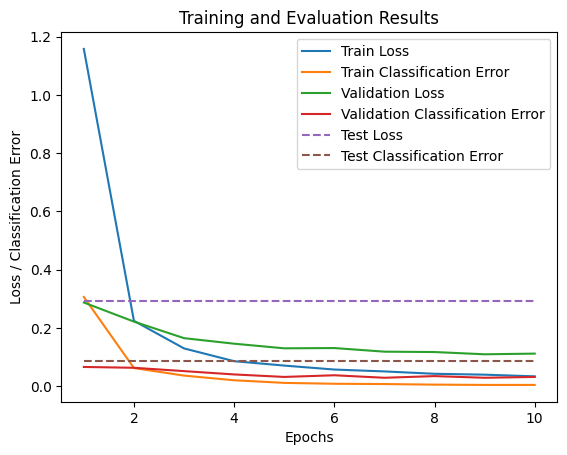

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.264663815498352
        average classification error => 0.3830000162124634

VALIDATION
        average validation loss => 0.403290718793869
        average validation classification error => 0.10857142508029938

EPOCH NUMBER 1
TRAINING
        average train loss => 0.27367115020751953
        average classification error => 0.07600000500679016

VALIDATION
        average validation loss => 0.21496662497520447
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 2
TRAINING
        average train loss => 0.15618237853050232
        average classification error => 0.04100000113248825

VALIDATION
        average validation loss => 0.20924071967601776
        average validation classification error => 0.05714285746216774

EPOCH NUMBER 3
TRAINING
        average train loss => 0.11873172223567963
        average classification error => 0.030000001192092896

VALIDATION
        average validation loss => 0.15

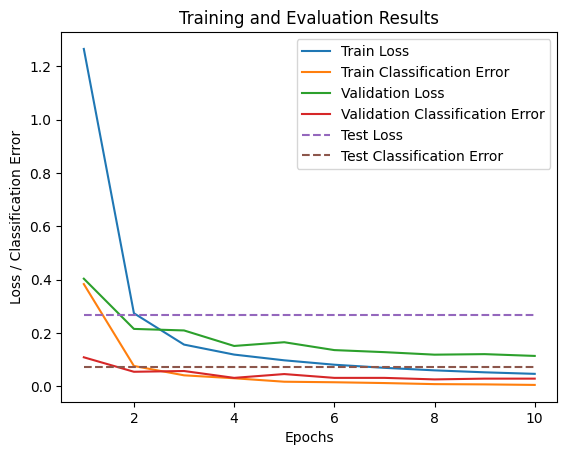

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.0683625936508179
        average classification error => 0.30100002884864807

VALIDATION
        average validation loss => 0.32392939925193787
        average validation classification error => 0.07999999821186066

EPOCH NUMBER 1
TRAINING
        average train loss => 0.21024015545845032
        average classification error => 0.055000003427267075

VALIDATION
        average validation loss => 0.19056956470012665
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 2
TRAINING
        average train loss => 0.12142305821180344
        average classification error => 0.03400000184774399

VALIDATION
        average validation loss => 0.14611993730068207
        average validation classification error => 0.034285712987184525

EPOCH NUMBER 3
TRAINING
        average train loss => 0.0913853645324707
        average classification error => 0.026000000536441803

VALIDATION
        average validation loss =

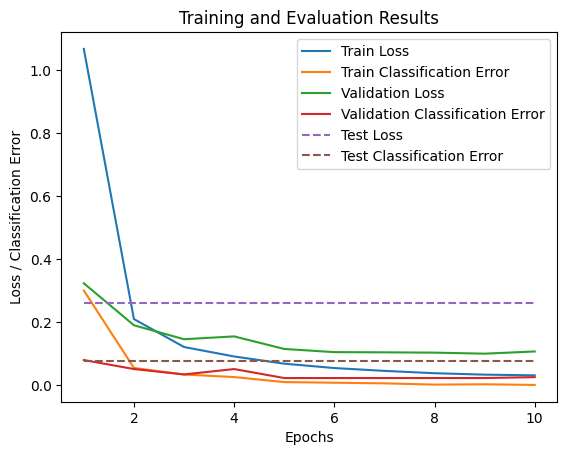

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.000991702079773
        average classification error => 0.29100000858306885

VALIDATION
        average validation loss => 0.3483680784702301
        average validation classification error => 0.10000000149011612

EPOCH NUMBER 1
TRAINING
        average train loss => 0.19797219336032867
        average classification error => 0.052000001072883606

VALIDATION
        average validation loss => 0.2031673789024353
        average validation classification error => 0.0657142847776413

EPOCH NUMBER 2
TRAINING
        average train loss => 0.11638490855693817
        average classification error => 0.02500000037252903

VALIDATION
        average validation loss => 0.17584501206874847
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 3
TRAINING
        average train loss => 0.08568225055932999
        average classification error => 0.017000000923871994

VALIDATION
        average validation loss => 0.1

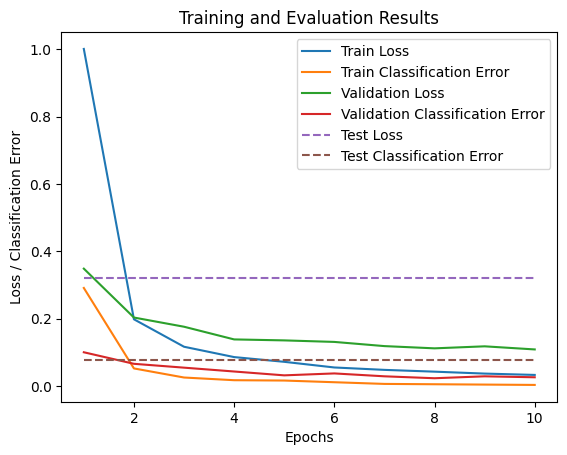

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 0.9870501756668091
        average classification error => 0.289000004529953

VALIDATION
        average validation loss => 0.23684267699718475
        average validation classification error => 0.05999999865889549

EPOCH NUMBER 1
TRAINING
        average train loss => 0.16040672361850739
        average classification error => 0.04100000113248825

VALIDATION
        average validation loss => 0.17131637036800385
        average validation classification error => 0.05714285746216774

EPOCH NUMBER 2
TRAINING
        average train loss => 0.09506727755069733
        average classification error => 0.02500000037252903

VALIDATION
        average validation loss => 0.14162811636924744
        average validation classification error => 0.04285714402794838

EPOCH NUMBER 3
TRAINING
        average train loss => 0.06984321027994156
        average classification error => 0.015000000596046448

VALIDATION
        average validation loss => 0.

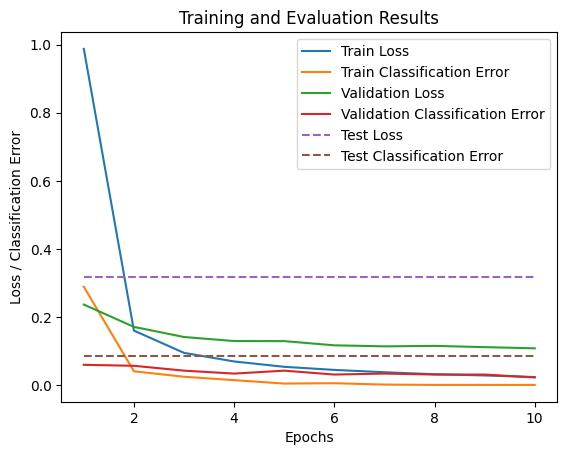

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.417158603668213
        average classification error => 0.36900001764297485

VALIDATION
        average validation loss => 0.4966568946838379
        average validation classification error => 0.10571428388357162

EPOCH NUMBER 1
TRAINING
        average train loss => 0.28661879897117615
        average classification error => 0.06800000369548798

VALIDATION
        average validation loss => 0.24812325835227966
        average validation classification error => 0.05999999865889549

EPOCH NUMBER 2
TRAINING
        average train loss => 0.1606791764497757
        average classification error => 0.039000000804662704

VALIDATION
        average validation loss => 0.2051210254430771
        average validation classification error => 0.04285714402794838

EPOCH NUMBER 3
TRAINING
        average train loss => 0.11139741539955139
        average classification error => 0.024000000208616257

VALIDATION
        average validation loss => 0.1

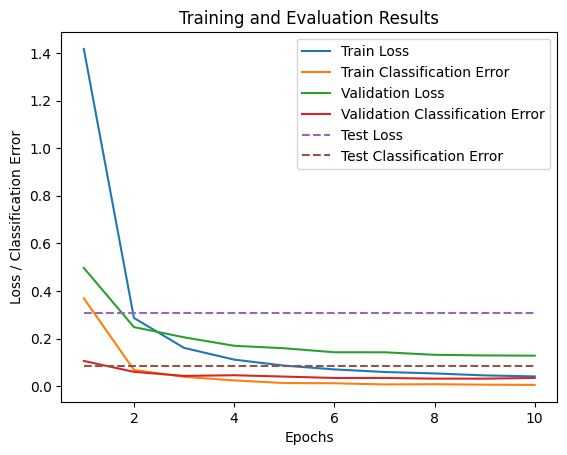

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 0.8613500595092773
        average classification error => 0.2550000250339508

VALIDATION
        average validation loss => 0.32417240738868713
        average validation classification error => 0.09714285284280777

EPOCH NUMBER 1
TRAINING
        average train loss => 0.16597944498062134
        average classification error => 0.04400000348687172

VALIDATION
        average validation loss => 0.18136073648929596
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 2
TRAINING
        average train loss => 0.09248381853103638
        average classification error => 0.023000001907348633

VALIDATION
        average validation loss => 0.15768593549728394
        average validation classification error => 0.04571428522467613

EPOCH NUMBER 3
TRAINING
        average train loss => 0.06806395202875137
        average classification error => 0.01600000075995922

VALIDATION
        average validation loss => 0

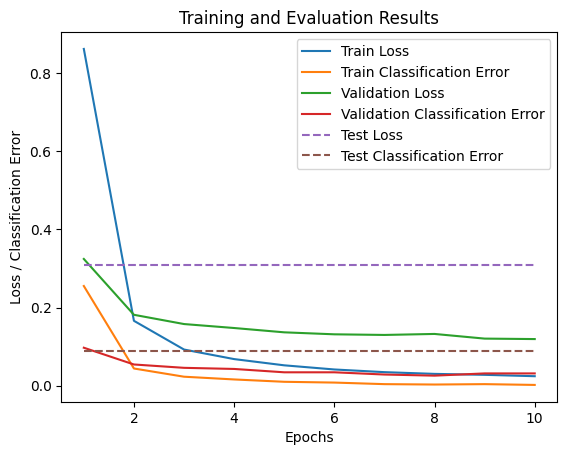

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.3343915939331055
        average classification error => 0.35200002789497375

VALIDATION
        average validation loss => 0.425846129655838
        average validation classification error => 0.08857142925262451

EPOCH NUMBER 1
TRAINING
        average train loss => 0.26825037598609924
        average classification error => 0.0690000057220459

VALIDATION
        average validation loss => 0.227044016122818
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 2
TRAINING
        average train loss => 0.1452406495809555
        average classification error => 0.032999999821186066

VALIDATION
        average validation loss => 0.19860373437404633
        average validation classification error => 0.05714285746216774

EPOCH NUMBER 3
TRAINING
        average train loss => 0.10832077264785767
        average classification error => 0.02500000037252903

VALIDATION
        average validation loss => 0.171

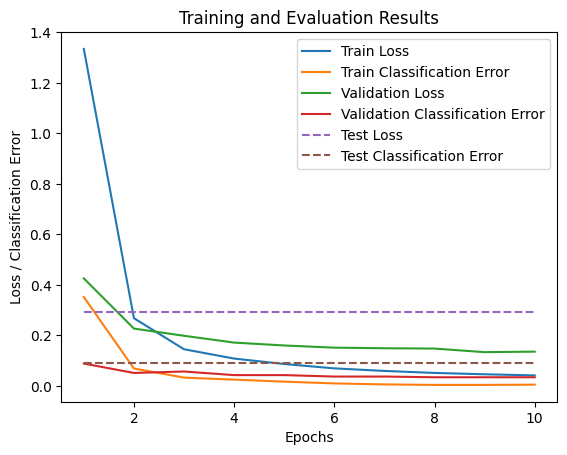

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.1537199020385742
        average classification error => 0.3190000057220459

VALIDATION
        average validation loss => 0.3579424321651459
        average validation classification error => 0.10571428388357162

EPOCH NUMBER 1
TRAINING
        average train loss => 0.23031923174858093
        average classification error => 0.06300000101327896

VALIDATION
        average validation loss => 0.2552374601364136
        average validation classification error => 0.0771428570151329

EPOCH NUMBER 2
TRAINING
        average train loss => 0.13957661390304565
        average classification error => 0.03700000047683716

VALIDATION
        average validation loss => 0.1662224382162094
        average validation classification error => 0.03999999910593033

EPOCH NUMBER 3
TRAINING
        average train loss => 0.09856272488832474
        average classification error => 0.021000001579523087

VALIDATION
        average validation loss => 0.148

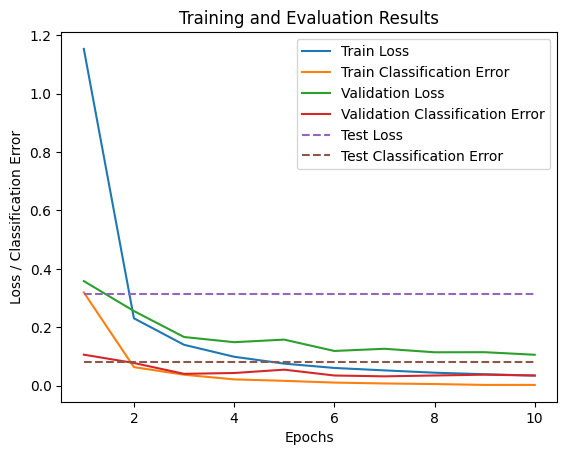

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 0.7935671806335449
        average classification error => 0.22700001299381256

VALIDATION
        average validation loss => 0.216726154088974
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 1
TRAINING
        average train loss => 0.13526566326618195
        average classification error => 0.03800000250339508

VALIDATION
        average validation loss => 0.19858989119529724
        average validation classification error => 0.05999999865889549

EPOCH NUMBER 2
TRAINING
        average train loss => 0.07997410744428635
        average classification error => 0.018000001087784767

VALIDATION
        average validation loss => 0.13853143155574799
        average validation classification error => 0.037142857909202576

EPOCH NUMBER 3
TRAINING
        average train loss => 0.0633637085556984
        average classification error => 0.012000000104308128

VALIDATION
        average validation loss => 

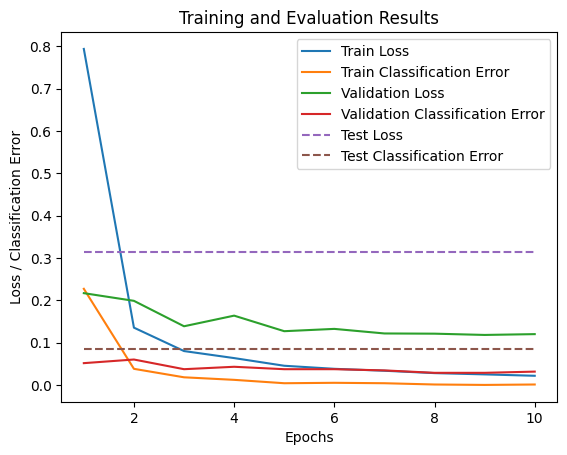

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.096574306488037
        average classification error => 0.2760000228881836

VALIDATION
        average validation loss => 0.29682761430740356
        average validation classification error => 0.0657142847776413

EPOCH NUMBER 1
TRAINING
        average train loss => 0.2070969194173813
        average classification error => 0.04700000211596489

VALIDATION
        average validation loss => 0.19147242605686188
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 2
TRAINING
        average train loss => 0.11980724334716797
        average classification error => 0.029000001028180122

VALIDATION
        average validation loss => 0.14844250679016113
        average validation classification error => 0.03999999910593033

EPOCH NUMBER 3
TRAINING
        average train loss => 0.08433160930871964
        average classification error => 0.02200000174343586

VALIDATION
        average validation loss => 0.1

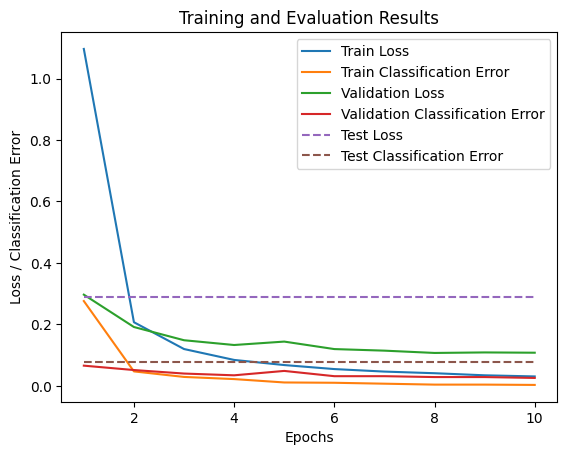

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.1869655847549438
        average classification error => 0.30300000309944153

VALIDATION
        average validation loss => 0.4218500256538391
        average validation classification error => 0.08857142925262451

EPOCH NUMBER 1
TRAINING
        average train loss => 0.2731969356536865
        average classification error => 0.0690000057220459

VALIDATION
        average validation loss => 0.211757093667984
        average validation classification error => 0.04285714402794838

EPOCH NUMBER 2
TRAINING
        average train loss => 0.15709854662418365
        average classification error => 0.0430000014603138

VALIDATION
        average validation loss => 0.18275465071201324
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 3
TRAINING
        average train loss => 0.10871854424476624
        average classification error => 0.02500000037252903

VALIDATION
        average validation loss => 0.1538

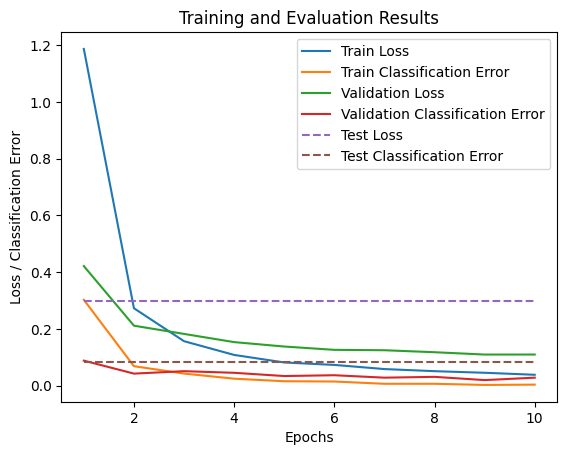

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.2677924633026123
        average classification error => 0.33900001645088196

VALIDATION
        average validation loss => 0.4205406904220581
        average validation classification error => 0.09142857044935226

EPOCH NUMBER 1
TRAINING
        average train loss => 0.26457417011260986
        average classification error => 0.0650000050663948

VALIDATION
        average validation loss => 0.2223445177078247
        average validation classification error => 0.05999999865889549

EPOCH NUMBER 2
TRAINING
        average train loss => 0.14668413996696472
        average classification error => 0.0430000014603138

VALIDATION
        average validation loss => 0.19330865144729614
        average validation classification error => 0.048571426421403885

EPOCH NUMBER 3
TRAINING
        average train loss => 0.10693333297967911
        average classification error => 0.024000000208616257

VALIDATION
        average validation loss => 0.1

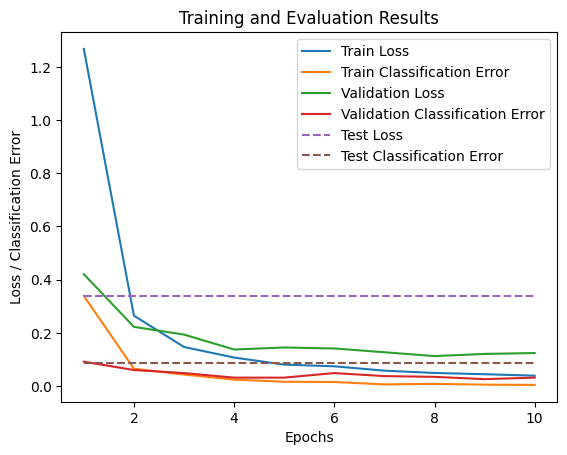

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.0632776021957397
        average classification error => 0.28200000524520874

VALIDATION
        average validation loss => 0.3568713963031769
        average validation classification error => 0.0657142847776413

EPOCH NUMBER 1
TRAINING
        average train loss => 0.22464898228645325
        average classification error => 0.05700000375509262

VALIDATION
        average validation loss => 0.2333516925573349
        average validation classification error => 0.05999999865889549

EPOCH NUMBER 2
TRAINING
        average train loss => 0.12558797001838684
        average classification error => 0.032999999821186066

VALIDATION
        average validation loss => 0.1845371276140213
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 3
TRAINING
        average train loss => 0.0955110415816307
        average classification error => 0.023000001907348633

VALIDATION
        average validation loss => 0.1

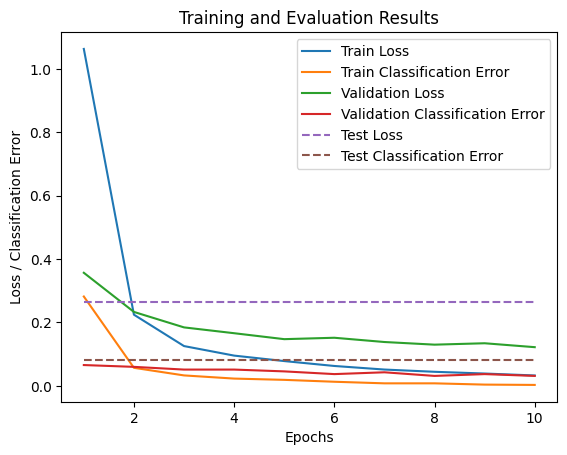

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.11197829246521
        average classification error => 0.33000001311302185

VALIDATION
        average validation loss => 0.4334389269351959
        average validation classification error => 0.10285714268684387

EPOCH NUMBER 1
TRAINING
        average train loss => 0.24509833753108978
        average classification error => 0.06300000101327896

VALIDATION
        average validation loss => 0.23684310913085938
        average validation classification error => 0.0714285671710968

EPOCH NUMBER 2
TRAINING
        average train loss => 0.1441914141178131
        average classification error => 0.039000000804662704

VALIDATION
        average validation loss => 0.1840374916791916
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 3
TRAINING
        average train loss => 0.10484585165977478
        average classification error => 0.026000000536441803

VALIDATION
        average validation loss => 0.177

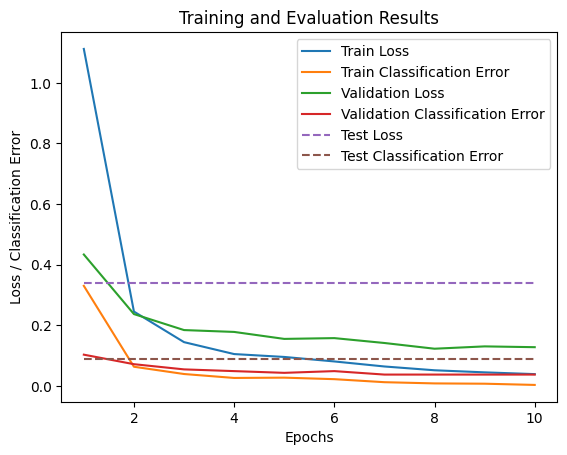

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.120370864868164
        average classification error => 0.30000001192092896

VALIDATION
        average validation loss => 0.43616941571235657
        average validation classification error => 0.09142857044935226

EPOCH NUMBER 1
TRAINING
        average train loss => 0.21884506940841675
        average classification error => 0.05300000309944153

VALIDATION
        average validation loss => 0.20687870681285858
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 2
TRAINING
        average train loss => 0.12139489501714706
        average classification error => 0.03100000135600567

VALIDATION
        average validation loss => 0.18330952525138855
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 3
TRAINING
        average train loss => 0.0828571543097496
        average classification error => 0.020000001415610313

VALIDATION
        average validation loss => 0.

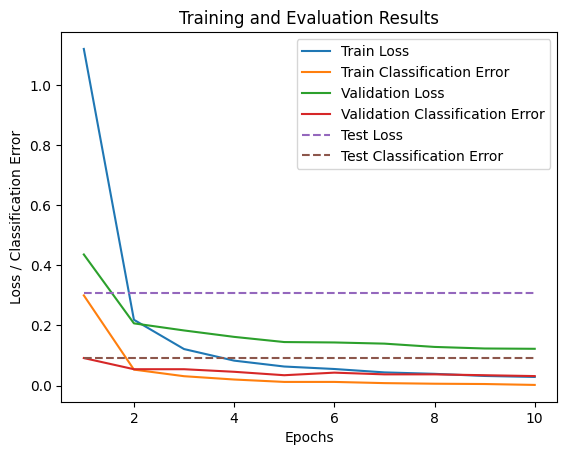

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.0610086917877197
        average classification error => 0.2750000059604645

VALIDATION
        average validation loss => 0.328494668006897
        average validation classification error => 0.0657142847776413

EPOCH NUMBER 1
TRAINING
        average train loss => 0.20598582923412323
        average classification error => 0.05100000277161598

VALIDATION
        average validation loss => 0.1914682686328888
        average validation classification error => 0.04571428522467613

EPOCH NUMBER 2
TRAINING
        average train loss => 0.11534668505191803
        average classification error => 0.032999999821186066

VALIDATION
        average validation loss => 0.1453816145658493
        average validation classification error => 0.034285712987184525

EPOCH NUMBER 3
TRAINING
        average train loss => 0.08360519260168076
        average classification error => 0.01900000125169754

VALIDATION
        average validation loss => 0.140

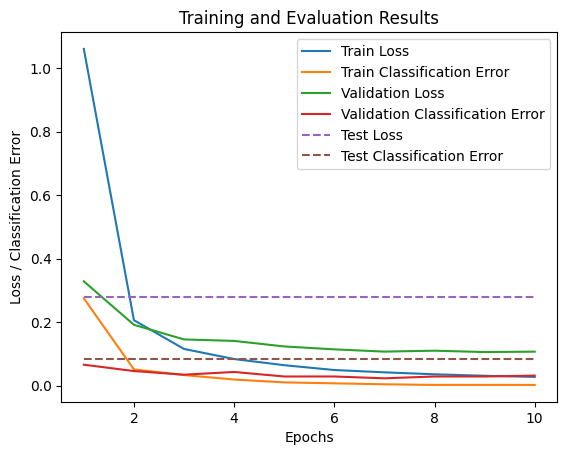

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.0321820974349976
        average classification error => 0.2900000214576721

VALIDATION
        average validation loss => 0.3711192011833191
        average validation classification error => 0.09714285284280777

EPOCH NUMBER 1
TRAINING
        average train loss => 0.2610222101211548
        average classification error => 0.08000000566244125

VALIDATION
        average validation loss => 0.25934433937072754
        average validation classification error => 0.08571428805589676

EPOCH NUMBER 2
TRAINING
        average train loss => 0.15813907980918884
        average classification error => 0.039000000804662704

VALIDATION
        average validation loss => 0.15918736159801483
        average validation classification error => 0.04571428522467613

EPOCH NUMBER 3
TRAINING
        average train loss => 0.10728352516889572
        average classification error => 0.029000001028180122

VALIDATION
        average validation loss => 0.

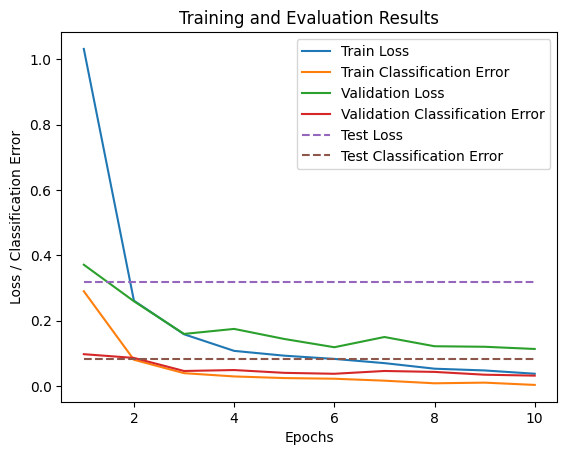

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.1091156005859375
        average classification error => 0.30300000309944153

VALIDATION
        average validation loss => 0.38538897037506104
        average validation classification error => 0.08857142925262451

EPOCH NUMBER 1
TRAINING
        average train loss => 0.20351405441761017
        average classification error => 0.04700000211596489

VALIDATION
        average validation loss => 0.20855817198753357
        average validation classification error => 0.048571426421403885

EPOCH NUMBER 2
TRAINING
        average train loss => 0.11045879870653152
        average classification error => 0.024000000208616257

VALIDATION
        average validation loss => 0.16469766199588776
        average validation classification error => 0.03999999910593033

EPOCH NUMBER 3
TRAINING
        average train loss => 0.08422932028770447
        average classification error => 0.021000001579523087

VALIDATION
        average validation loss =

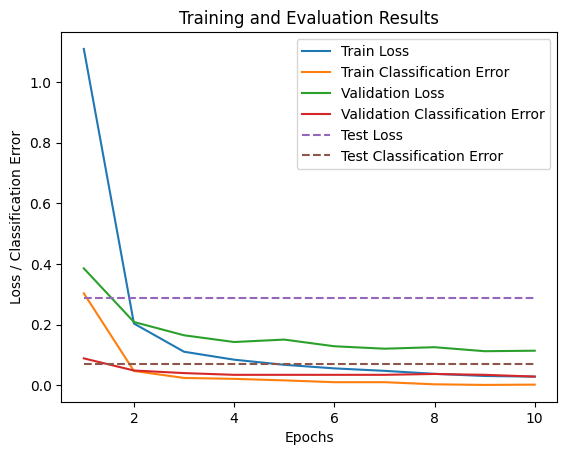

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.2981019020080566
        average classification error => 0.3440000116825104

VALIDATION
        average validation loss => 0.5046725273132324
        average validation classification error => 0.10857142508029938

EPOCH NUMBER 1
TRAINING
        average train loss => 0.31193864345550537
        average classification error => 0.08100000023841858

VALIDATION
        average validation loss => 0.2393326610326767
        average validation classification error => 0.0657142847776413

EPOCH NUMBER 2
TRAINING
        average train loss => 0.16711409389972687
        average classification error => 0.04100000113248825

VALIDATION
        average validation loss => 0.17701920866966248
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 3
TRAINING
        average train loss => 0.1220412477850914
        average classification error => 0.03200000151991844

VALIDATION
        average validation loss => 0.145

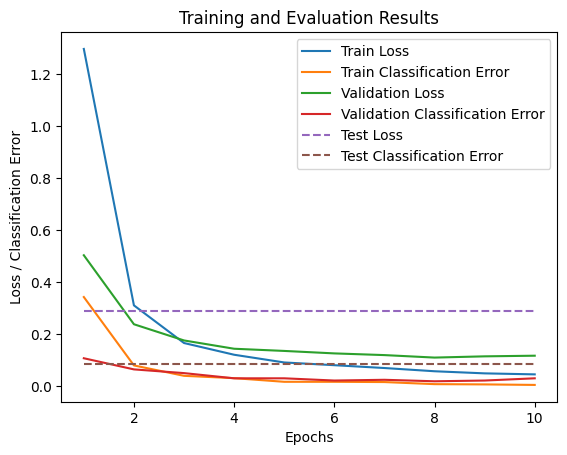

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.182422161102295
        average classification error => 0.3050000071525574

VALIDATION
        average validation loss => 0.4037856161594391
        average validation classification error => 0.09142857044935226

EPOCH NUMBER 1
TRAINING
        average train loss => 0.23688861727714539
        average classification error => 0.06100000441074371

VALIDATION
        average validation loss => 0.2078479677438736
        average validation classification error => 0.048571426421403885

EPOCH NUMBER 2
TRAINING
        average train loss => 0.1314208060503006
        average classification error => 0.036000002175569534

VALIDATION
        average validation loss => 0.17769594490528107
        average validation classification error => 0.037142857909202576

EPOCH NUMBER 3
TRAINING
        average train loss => 0.09575742483139038
        average classification error => 0.023000001907348633

VALIDATION
        average validation loss => 0.

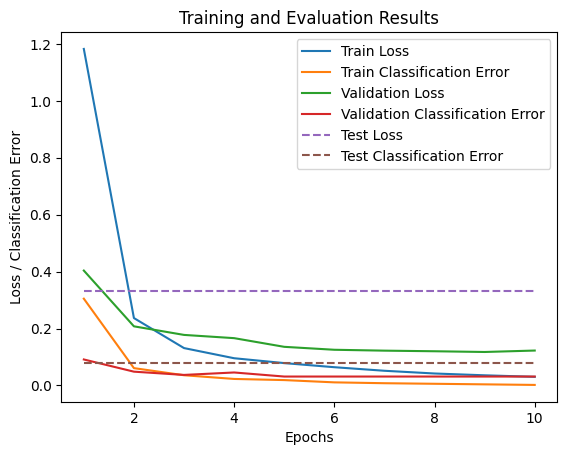

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.27872896194458
        average classification error => 0.3440000116825104

VALIDATION
        average validation loss => 0.4914019703865051
        average validation classification error => 0.11714285612106323

EPOCH NUMBER 1
TRAINING
        average train loss => 0.2774478495121002
        average classification error => 0.06400000303983688

VALIDATION
        average validation loss => 0.23331093788146973
        average validation classification error => 0.0714285671710968

EPOCH NUMBER 2
TRAINING
        average train loss => 0.14942829310894012
        average classification error => 0.03700000047683716

VALIDATION
        average validation loss => 0.18635304272174835
        average validation classification error => 0.048571426421403885

EPOCH NUMBER 3
TRAINING
        average train loss => 0.11166492849588394
        average classification error => 0.027000000700354576

VALIDATION
        average validation loss => 0.151

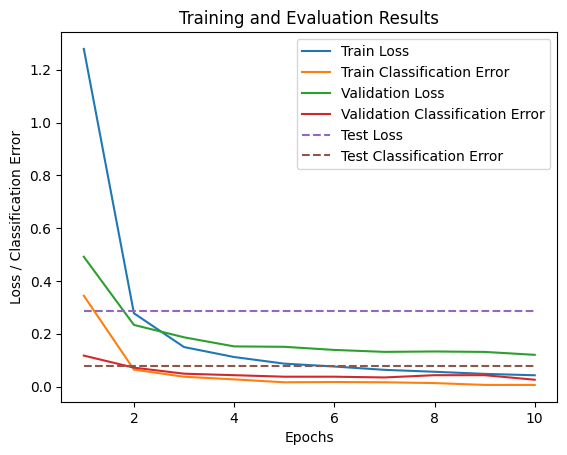

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.1492093801498413
        average classification error => 0.3270000219345093

VALIDATION
        average validation loss => 0.4342128038406372
        average validation classification error => 0.08571428805589676

EPOCH NUMBER 1
TRAINING
        average train loss => 0.30178022384643555
        average classification error => 0.08100000023841858

VALIDATION
        average validation loss => 0.24883440136909485
        average validation classification error => 0.0714285671710968

EPOCH NUMBER 2
TRAINING
        average train loss => 0.1677742898464203
        average classification error => 0.04400000348687172

VALIDATION
        average validation loss => 0.19912776350975037
        average validation classification error => 0.05714285746216774

EPOCH NUMBER 3
TRAINING
        average train loss => 0.11503374576568604
        average classification error => 0.027000000700354576

VALIDATION
        average validation loss => 0.16

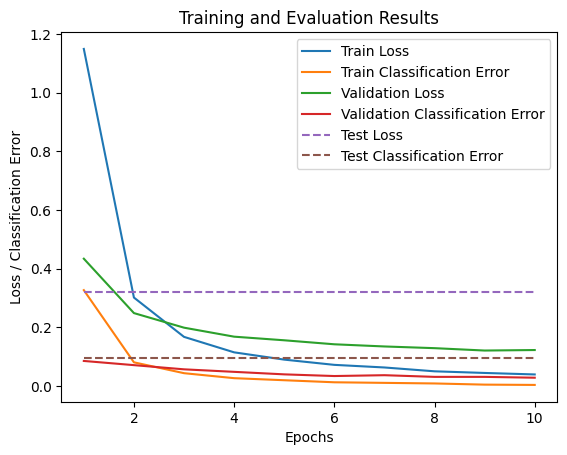

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.207297444343567
        average classification error => 0.31200000643730164

VALIDATION
        average validation loss => 0.3857310116291046
        average validation classification error => 0.07999999821186066

EPOCH NUMBER 1
TRAINING
        average train loss => 0.25803545117378235
        average classification error => 0.05300000309944153

VALIDATION
        average validation loss => 0.2030279040336609
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 2
TRAINING
        average train loss => 0.1564958393573761
        average classification error => 0.04000000283122063

VALIDATION
        average validation loss => 0.16482165455818176
        average validation classification error => 0.04571428522467613

EPOCH NUMBER 3
TRAINING
        average train loss => 0.11523603647947311
        average classification error => 0.03500000014901161

VALIDATION
        average validation loss => 0.141

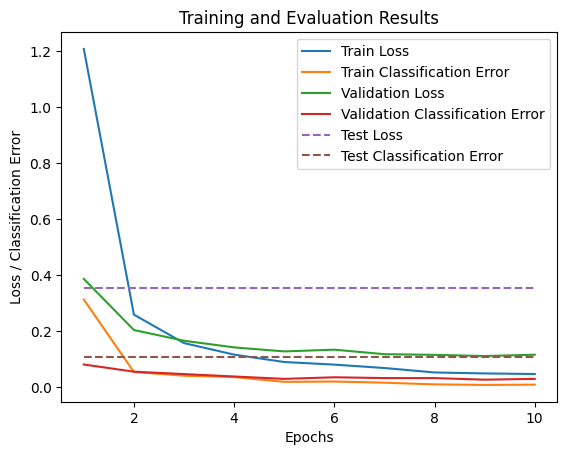

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.00640070438385
        average classification error => 0.2939999997615814

VALIDATION
        average validation loss => 0.4002256393432617
        average validation classification error => 0.12285713851451874

EPOCH NUMBER 1
TRAINING
        average train loss => 0.23350118100643158
        average classification error => 0.058000002056360245

VALIDATION
        average validation loss => 0.23683874309062958
        average validation classification error => 0.0714285671710968

EPOCH NUMBER 2
TRAINING
        average train loss => 0.13593690097332
        average classification error => 0.030000001192092896

VALIDATION
        average validation loss => 0.18071207404136658
        average validation classification error => 0.048571426421403885

EPOCH NUMBER 3
TRAINING
        average train loss => 0.09309488534927368
        average classification error => 0.024000000208616257

VALIDATION
        average validation loss => 0.148

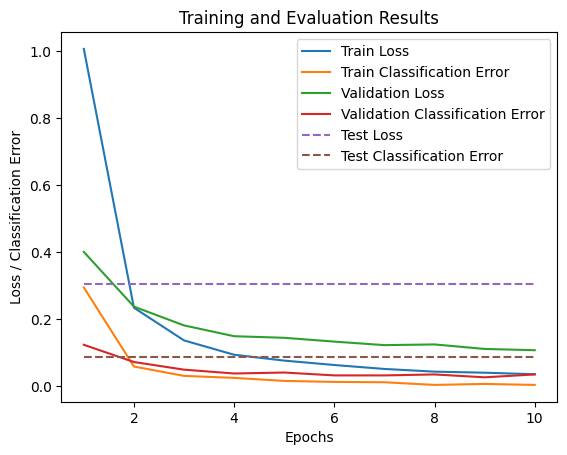

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.039551854133606
        average classification error => 0.2840000092983246

VALIDATION
        average validation loss => 0.4283968210220337
        average validation classification error => 0.1257142871618271

EPOCH NUMBER 1
TRAINING
        average train loss => 0.22290995717048645
        average classification error => 0.05300000309944153

VALIDATION
        average validation loss => 0.23821385204792023
        average validation classification error => 0.08571428805589676

EPOCH NUMBER 2
TRAINING
        average train loss => 0.13140687346458435
        average classification error => 0.03500000014901161

VALIDATION
        average validation loss => 0.1646830141544342
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 3
TRAINING
        average train loss => 0.09159938991069794
        average classification error => 0.01900000125169754

VALIDATION
        average validation loss => 0.152

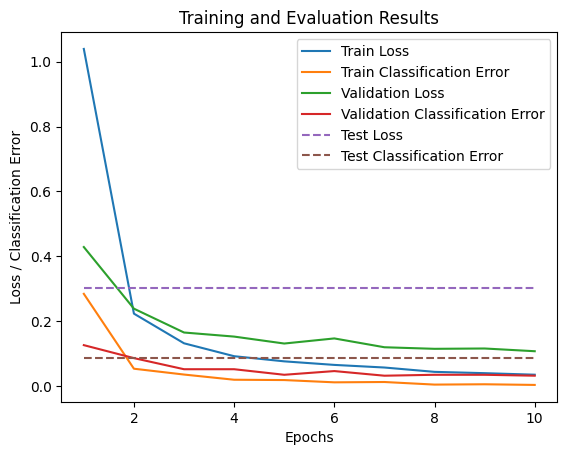

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.0167367458343506
        average classification error => 0.2540000081062317

VALIDATION
        average validation loss => 0.3353438973426819
        average validation classification error => 0.0714285671710968

EPOCH NUMBER 1
TRAINING
        average train loss => 0.213209867477417
        average classification error => 0.049000002443790436

VALIDATION
        average validation loss => 0.20292790234088898
        average validation classification error => 0.05999999865889549

EPOCH NUMBER 2
TRAINING
        average train loss => 0.12539714574813843
        average classification error => 0.030000001192092896

VALIDATION
        average validation loss => 0.16950473189353943
        average validation classification error => 0.048571426421403885

EPOCH NUMBER 3
TRAINING
        average train loss => 0.0887041985988617
        average classification error => 0.015000000596046448

VALIDATION
        average validation loss => 0.1

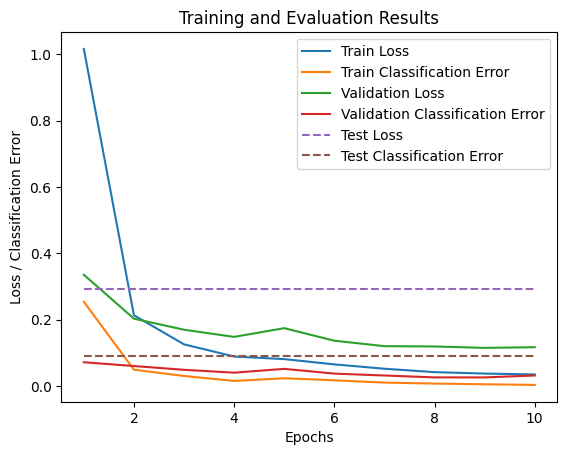

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.088828444480896
        average classification error => 0.3020000159740448

VALIDATION
        average validation loss => 0.41818663477897644
        average validation classification error => 0.10857142508029938

EPOCH NUMBER 1
TRAINING
        average train loss => 0.24383118748664856
        average classification error => 0.06599999964237213

VALIDATION
        average validation loss => 0.250210702419281
        average validation classification error => 0.0771428570151329

EPOCH NUMBER 2
TRAINING
        average train loss => 0.13770824670791626
        average classification error => 0.03700000047683716

VALIDATION
        average validation loss => 0.17850787937641144
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 3
TRAINING
        average train loss => 0.10072346031665802
        average classification error => 0.02500000037252903

VALIDATION
        average validation loss => 0.176

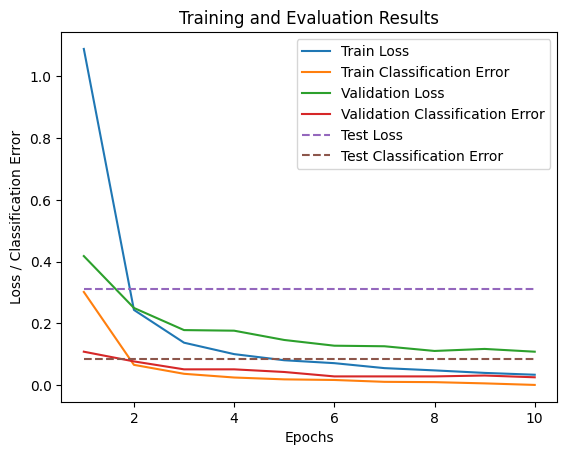

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.0710422992706299
        average classification error => 0.3050000071525574

VALIDATION
        average validation loss => 0.35348325967788696
        average validation classification error => 0.08571428805589676

EPOCH NUMBER 1
TRAINING
        average train loss => 0.21130862832069397
        average classification error => 0.04700000211596489

VALIDATION
        average validation loss => 0.20377831161022186
        average validation classification error => 0.06285714358091354

EPOCH NUMBER 2
TRAINING
        average train loss => 0.11262242496013641
        average classification error => 0.03100000135600567

VALIDATION
        average validation loss => 0.16653938591480255
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 3
TRAINING
        average train loss => 0.0866784155368805
        average classification error => 0.015000000596046448

VALIDATION
        average validation loss => 0

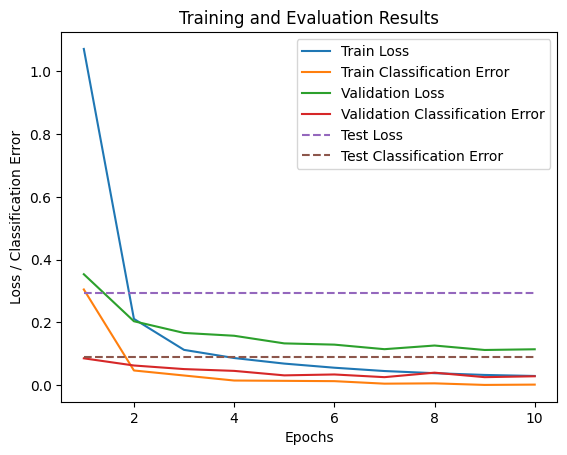

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.216034173965454
        average classification error => 0.31200000643730164

VALIDATION
        average validation loss => 0.5461927652359009
        average validation classification error => 0.17428570985794067

EPOCH NUMBER 1
TRAINING
        average train loss => 0.27643606066703796
        average classification error => 0.0690000057220459

VALIDATION
        average validation loss => 0.27647703886032104
        average validation classification error => 0.07428571581840515

EPOCH NUMBER 2
TRAINING
        average train loss => 0.15122723579406738
        average classification error => 0.04100000113248825

VALIDATION
        average validation loss => 0.2135007083415985
        average validation classification error => 0.05999999865889549

EPOCH NUMBER 3
TRAINING
        average train loss => 0.10338681191205978
        average classification error => 0.024000000208616257

VALIDATION
        average validation loss => 0.17

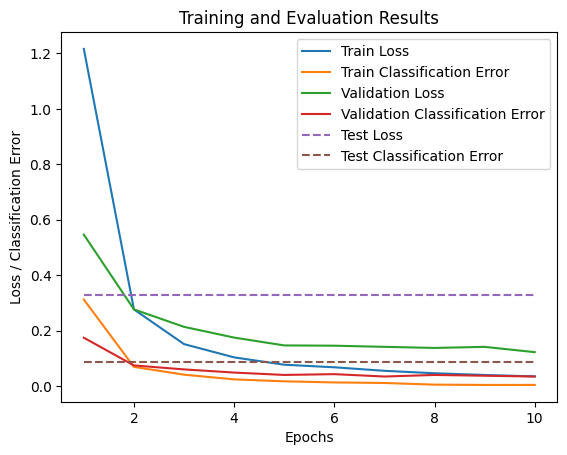

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.2854619026184082
        average classification error => 0.33800002932548523

VALIDATION
        average validation loss => 0.48401039838790894
        average validation classification error => 0.09428571164608002

EPOCH NUMBER 1
TRAINING
        average train loss => 0.27907615900039673
        average classification error => 0.07300000637769699

VALIDATION
        average validation loss => 0.235044464468956
        average validation classification error => 0.05714285746216774

EPOCH NUMBER 2
TRAINING
        average train loss => 0.14639818668365479
        average classification error => 0.04000000283122063

VALIDATION
        average validation loss => 0.18112172186374664
        average validation classification error => 0.04571428522467613

EPOCH NUMBER 3
TRAINING
        average train loss => 0.10463762283325195
        average classification error => 0.024000000208616257

VALIDATION
        average validation loss => 0.

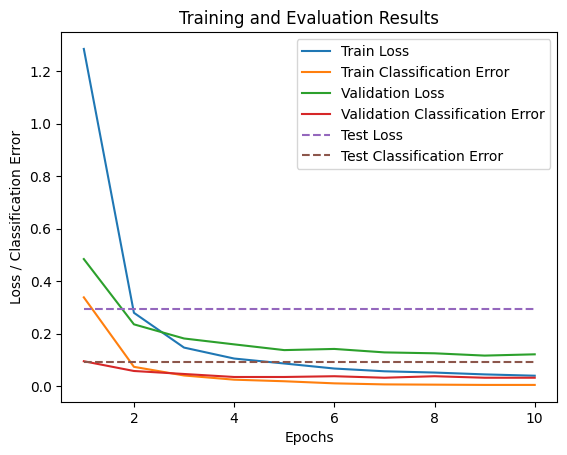

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.2867428064346313
        average classification error => 0.3320000171661377

VALIDATION
        average validation loss => 0.4659078121185303
        average validation classification error => 0.06857142597436905

EPOCH NUMBER 1
TRAINING
        average train loss => 0.30223774909973145
        average classification error => 0.06800000369548798

VALIDATION
        average validation loss => 0.25467294454574585
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 2
TRAINING
        average train loss => 0.16756540536880493
        average classification error => 0.04400000348687172

VALIDATION
        average validation loss => 0.19285409152507782
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 3
TRAINING
        average train loss => 0.12139637023210526
        average classification error => 0.036000002175569534

VALIDATION
        average validation loss => 0.

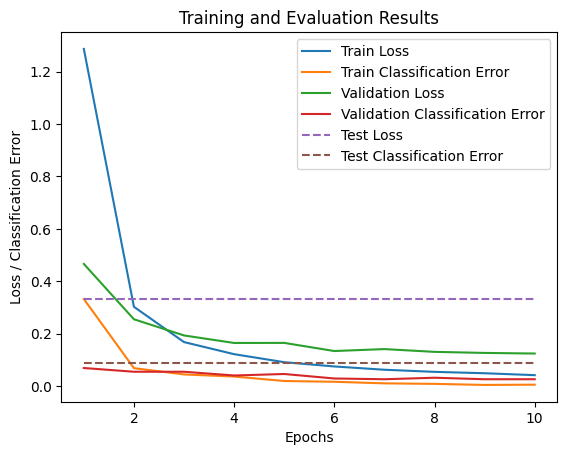

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.31522536277771
        average classification error => 0.3710000216960907

VALIDATION
        average validation loss => 0.5444495677947998
        average validation classification error => 0.14000000059604645

EPOCH NUMBER 1
TRAINING
        average train loss => 0.31919652223587036
        average classification error => 0.07400000095367432

VALIDATION
        average validation loss => 0.27836188673973083
        average validation classification error => 0.06857142597436905

EPOCH NUMBER 2
TRAINING
        average train loss => 0.16669020056724548
        average classification error => 0.04200000315904617

VALIDATION
        average validation loss => 0.18709585070610046
        average validation classification error => 0.048571426421403885

EPOCH NUMBER 3
TRAINING
        average train loss => 0.11176738142967224
        average classification error => 0.02500000037252903

VALIDATION
        average validation loss => 0.16

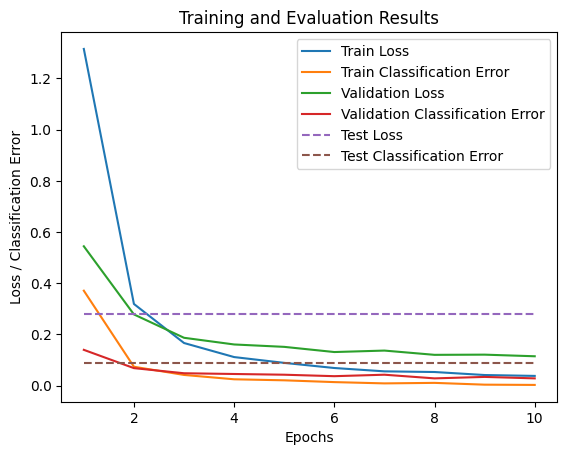

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.1570550203323364
        average classification error => 0.3050000071525574

VALIDATION
        average validation loss => 0.44423621892929077
        average validation classification error => 0.10857142508029938

EPOCH NUMBER 1
TRAINING
        average train loss => 0.26847222447395325
        average classification error => 0.07200000435113907

VALIDATION
        average validation loss => 0.2575555145740509
        average validation classification error => 0.05999999865889549

EPOCH NUMBER 2
TRAINING
        average train loss => 0.13862429559230804
        average classification error => 0.03500000014901161

VALIDATION
        average validation loss => 0.20330683887004852
        average validation classification error => 0.0657142847776413

EPOCH NUMBER 3
TRAINING
        average train loss => 0.10494141280651093
        average classification error => 0.024000000208616257

VALIDATION
        average validation loss => 0.1

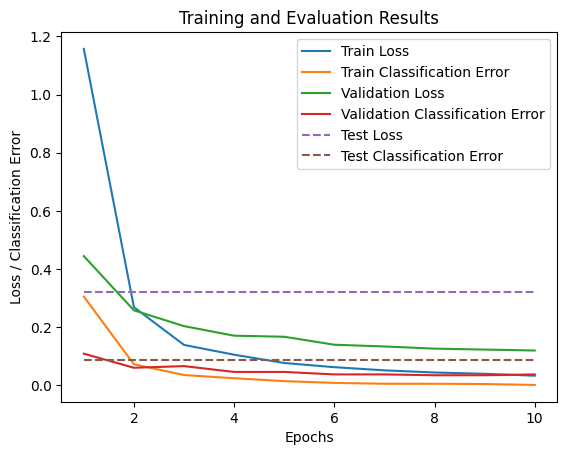

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.1636133193969727
        average classification error => 0.31800001859664917

VALIDATION
        average validation loss => 0.4258074462413788
        average validation classification error => 0.08571428805589676

EPOCH NUMBER 1
TRAINING
        average train loss => 0.23882630467414856
        average classification error => 0.06599999964237213

VALIDATION
        average validation loss => 0.22808168828487396
        average validation classification error => 0.05999999865889549

EPOCH NUMBER 2
TRAINING
        average train loss => 0.12857899069786072
        average classification error => 0.030000001192092896

VALIDATION
        average validation loss => 0.16209347546100616
        average validation classification error => 0.037142857909202576

EPOCH NUMBER 3
TRAINING
        average train loss => 0.09087501466274261
        average classification error => 0.018000001087784767

VALIDATION
        average validation loss =>

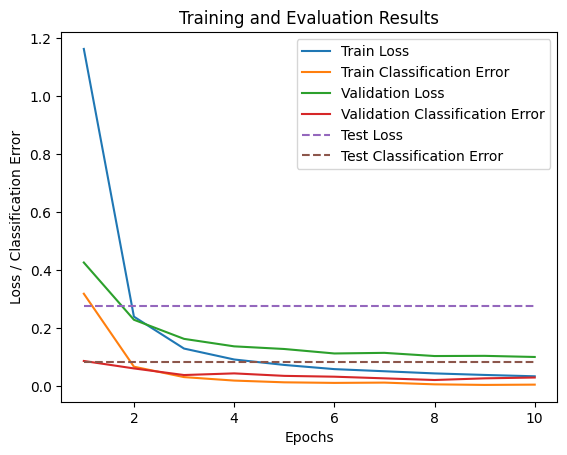

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.0682390928268433
        average classification error => 0.25600001215934753

VALIDATION
        average validation loss => 0.3446725010871887
        average validation classification error => 0.06857142597436905

EPOCH NUMBER 1
TRAINING
        average train loss => 0.20670905709266663
        average classification error => 0.04700000211596489

VALIDATION
        average validation loss => 0.20245176553726196
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 2
TRAINING
        average train loss => 0.11444514244794846
        average classification error => 0.03100000135600567

VALIDATION
        average validation loss => 0.1628006398677826
        average validation classification error => 0.04571428522467613

EPOCH NUMBER 3
TRAINING
        average train loss => 0.08754415810108185
        average classification error => 0.024000000208616257

VALIDATION
        average validation loss => 0

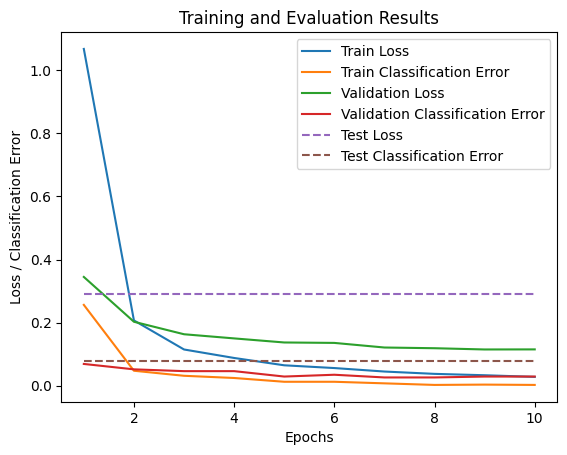

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 0.8925879001617432
        average classification error => 0.2510000169277191

VALIDATION
        average validation loss => 0.2565747797489166
        average validation classification error => 0.05714285746216774

EPOCH NUMBER 1
TRAINING
        average train loss => 0.16854076087474823
        average classification error => 0.04400000348687172

VALIDATION
        average validation loss => 0.20076559484004974
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 2
TRAINING
        average train loss => 0.1055406779050827
        average classification error => 0.030000001192092896

VALIDATION
        average validation loss => 0.13154596090316772
        average validation classification error => 0.03999999910593033

EPOCH NUMBER 3
TRAINING
        average train loss => 0.073356494307518
        average classification error => 0.017000000923871994

VALIDATION
        average validation loss => 0.12

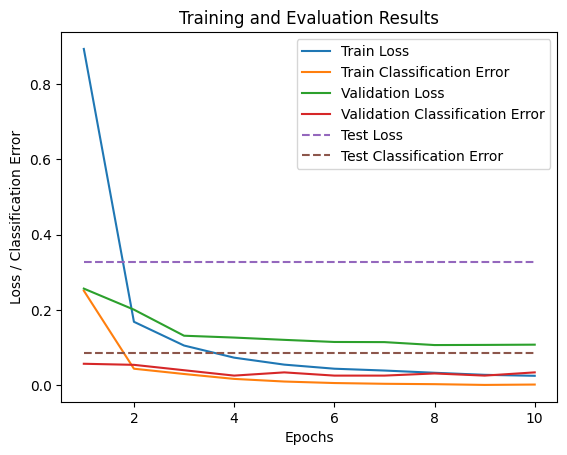

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.0336627960205078
        average classification error => 0.30100002884864807

VALIDATION
        average validation loss => 0.3837786018848419
        average validation classification error => 0.09714285284280777

EPOCH NUMBER 1
TRAINING
        average train loss => 0.2373572587966919
        average classification error => 0.06400000303983688

VALIDATION
        average validation loss => 0.22382330894470215
        average validation classification error => 0.0657142847776413

EPOCH NUMBER 2
TRAINING
        average train loss => 0.13704471290111542
        average classification error => 0.03800000250339508

VALIDATION
        average validation loss => 0.1911964863538742
        average validation classification error => 0.06857142597436905

EPOCH NUMBER 3
TRAINING
        average train loss => 0.1006232500076294
        average classification error => 0.02500000037252903

VALIDATION
        average validation loss => 0.1484

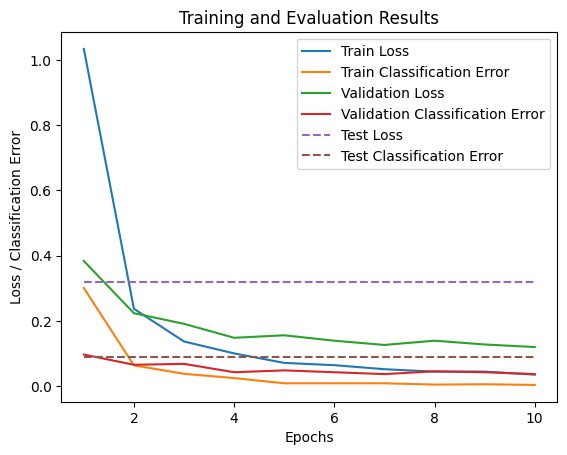

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.203635811805725
        average classification error => 0.3150000274181366

VALIDATION
        average validation loss => 0.416983038187027
        average validation classification error => 0.11142857372760773

EPOCH NUMBER 1
TRAINING
        average train loss => 0.23565395176410675
        average classification error => 0.06100000441074371

VALIDATION
        average validation loss => 0.20043107867240906
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 2
TRAINING
        average train loss => 0.12529250979423523
        average classification error => 0.030000001192092896

VALIDATION
        average validation loss => 0.16582198441028595
        average validation classification error => 0.04571428522467613

EPOCH NUMBER 3
TRAINING
        average train loss => 0.08744640648365021
        average classification error => 0.020000001415610313

VALIDATION
        average validation loss => 0.1

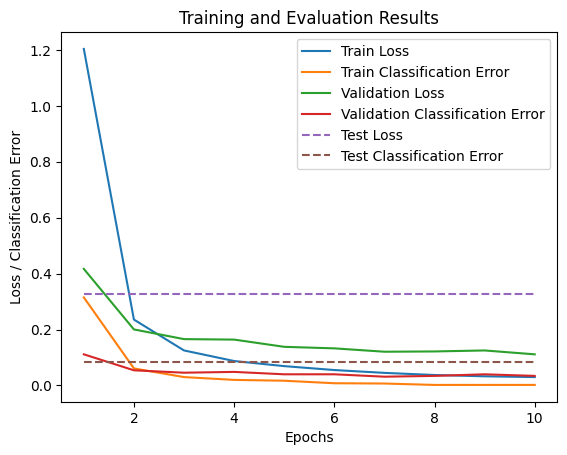

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 0.9622968435287476
        average classification error => 0.2590000033378601

VALIDATION
        average validation loss => 0.285593718290329
        average validation classification error => 0.06285714358091354

EPOCH NUMBER 1
TRAINING
        average train loss => 0.19645830988883972
        average classification error => 0.05300000309944153

VALIDATION
        average validation loss => 0.17650136351585388
        average validation classification error => 0.04285714402794838

EPOCH NUMBER 2
TRAINING
        average train loss => 0.11532870680093765
        average classification error => 0.030000001192092896

VALIDATION
        average validation loss => 0.1408182829618454
        average validation classification error => 0.03142857179045677

EPOCH NUMBER 3
TRAINING
        average train loss => 0.09142186492681503
        average classification error => 0.02200000174343586

VALIDATION
        average validation loss => 0.14

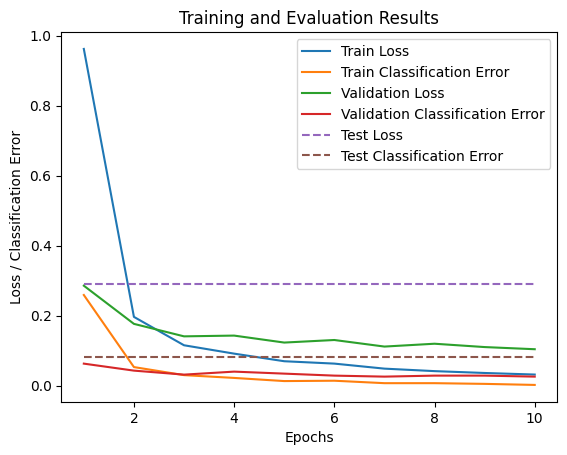

List of best individuals of each generation:
[[1, 1, 0, 2, 0, 2, 4], array([1, 0, 0, 2, 1, 0, 7]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([1, 0, 4, 3, 1, 0, 4]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([2, 0, 4, 4, 0, 2, 8]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), array([1, 0, 4, 3, 0, 0, 9]), a

In [36]:
#testing the best models
test_loss_for_each_generation = []
test_ce_for_each_generation = []

#for each model, train it and test it
for model in best_individual:
  #from genotype to phenotype
  params = EA.nn_from_genotype(model)

  best_model = CNN(conv_out = params[0],
                   kernel_params = params[1], 
                   f1 = params[2],
                   f2 = params[3],                 
                   pool_size = params[4],
                   pooling = params[5],
                   linear_out = params[6])
  best_model.to(device)
  #properly train and test the model
  #dataloaders are initialized before
  test_loss, test_ce = full_cnn_loop(model = best_model, number_epoch = 10, testing = True, 
                                               training_loader = training_loader, 
                                               val_loader = val_loader, 
                                               test_loader = test_loader, 
                                               verbose = True)
  
  test_loss_for_each_generation.append(test_loss)
  test_ce_for_each_generation.append(test_ce)




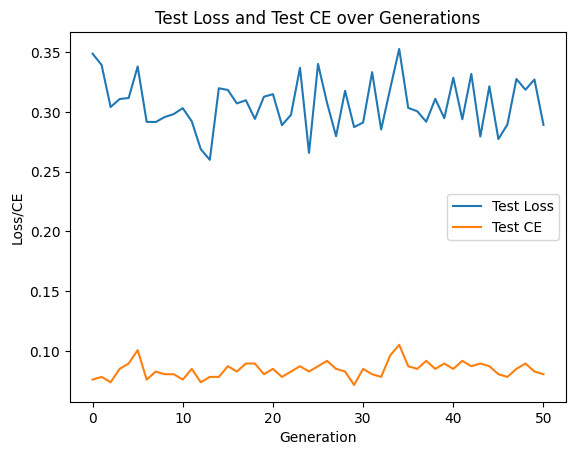

In [37]:
#plotting test loss and test ce over generations
plt.plot(test_loss_for_each_generation, label='Test Loss')
plt.plot(test_ce_for_each_generation, label='Test CE')

#adding labels and title
plt.xlabel('Generation')
plt.ylabel('Loss/CE')
plt.title('Test Loss and Test CE over Generations')
plt.legend()

#display
plt.show()

In [41]:
overall_best_ce =  min(test_ce_for_each_generation)
best_generation = test_ce_for_each_generation.index(overall_best_ce)

overall_best_geno = best_individual[best_generation]

print(f"\033[92mOVERALL RESULTS:\033[0m")
print("")
print(f"The best generation was generation number {best_generation}")
print(f"The best architecture genotype was:  {overall_best_geno}")
print(f"Which achieved a test Classification Error of:  {overall_best_ce}")

OVERALL RESULTS:

The best generation was generation number 29
The best architecture genotype was:  [1 0 4 3 0 0 9]
Which achieved a test Classification Error of:  0.07158836722373962
